<a href="https://colab.research.google.com/github/ParsaRouzrokh/PyTorch_Brain_Tumor_Segmentation_2D/blob/main/Brain_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Semantic Segmentation Model Trained on 2D MRI Slices

Author: Parsa Rouzrokh, MD, MPH

In this deep learning project, I plan to train a semantic segmentation model on a Brain Tumor 2D MRI Slices database, provided by Balakrishna Kumar.

I'll use MONAI and PyTorch libraries for data wrangling and creating models.

T4 GPU of google colab will be used for this session.

Table of Contents:

*   Intro 1: Installing Libraries
*   Intro 2: Importing Necessary Modules
*   Intro 3: Deterministic Programming
*   Part 1: Data Collection
*   Part 2: Data Wrangling / Analysis / Preprocessing Steps
   - Part 2.1: First Glance
   - Part 2.2: Creating Primary Frame
   - Part 2.3: Exploratory Data Analysis (EDA)
   - Part 2.4: Mask Modifications
   - Part 2.5: Splitting data and Finalizing the Frame
   - Part 2.6: Creating Train/Val/Test lists
   - Part 2.7: Building Data Loaders

*   Part 3: Loading the Model's Architecture
*   Part 4: Training the Model for Locating ROI
    - Part 4.1: Defining A Metric Function
    - Part 4.2: Defining A Loss Function
    - Part 4.3: Evaluating the Untrained Model's Performance to Determine Our Baseline
    - Part 4.4: Building A Trainer
    - Part 4.5: Training a Model (UFlex)
    - Part 4.6: Training a Model (CustomUNet)

*   Part 5: Evaluating the Trained Models
    - Part 5.1: Evaluating Trained Uflex
    - Part 5.2: Evaluating Trained CustomUNet











---



# **Intro 1: Installing Libraries**
We start by installing required libraries for this project:


*   MONAI
*   TorchInfo



In [1]:
!pip install monai
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.3 MB/s eta 0:00:00




---



# **Intro 2: Importing Necessary Modules**

This sample segmentation project is using the mentioned standard/third-party modules:



In [2]:
# Standard library modules
import glob
import os
import random
import shutil
import hashlib

# Third-party library modules
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.modules.upsampling import Upsample
import torch.nn.init as init
from torchinfo import summary
import monai as mn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm
from google.colab import files
from sklearn.model_selection import StratifiedGroupKFold
from functools import wraps
from typing import List, Dict, Tuple, Union, Callable, Iterable, Text
import warnings

warnings.filterwarnings("ignore")

# The line below is critical for almost every DL program!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Intro 3: Deterministic Programming**

With assigning a specific seed to our third-party modules or custom functions, we keep getting the same outputs in different parts of our session.

In [3]:
def determinate(fn):
  """
    Deterministic programming using a decorator with assigning a specific seed
    to our third-party library modules, as needed. (MONAI, Torch, etc.)
  """
  @wraps(fn)
  def wrapper(*args, **kwargs):
    if 'random_seed' in kwargs:
      random_seed = kwargs['random_seed']
    else:
      random_seed = 1234
    np.random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    mn.utils.misc.set_determinism(seed=random_seed)
    return fn(*args, **kwargs)
  return wrapper


# **Part 1: Data Collection**



Title of Dataset: Brain 2D MRI Images and Mask

Provided by: Balakrishna Kumar

Description: 4715 (.h5) files containing:

1.   The actual 2D Brain Images (FLAIR channel)
2.   Corresponding masks for tumor segmentation

Extracted from 3D BraTS-2019

Link:
https://www.kaggle.com/datasets/balakrishcodes/brain-2d-mri-imgs-and-mask

In [4]:
def get_kaggle_dataset():
  """
    Objectives:
      1) Uploading "Kaggle.json" to interact with Kaggle API from local host
      2) Downloading dataset from API using the provided API command from Kaggle
      3) Unzipping the zip file
  """
  # 1:
  files.upload()
  !rm -r ~/.kaggle
  !mkdir ~/.kaggle
  !mv ./kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  # 2:
  !kaggle datasets download -d balakrishcodes/brain-2d-mri-imgs-and-mask
  !rm -rf ./sample_data/

  # 3:
  !unzip -q brain-2d-mri-imgs-and-mask.zip
  os.remove('brain-2d-mri-imgs-and-mask.zip')

get_kaggle_dataset()

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
 90% 152M/168M [00:02<00:00, 92.6MB/s]
100% 168M/168M [00:02<00:00, 71.8MB/s]




---



# **Part 2: Data Wrangling / Analysis / Preprocessing Steps**

**Part 2.1: First Glance**

Since we have not enough information about the dataset, it's better to start
with a first-glance analysis!

Chosen Sample from All H5 Files: BRATS_424/BRATS_424_104.h5

HDF5 dataset contents:
<HDF5 dataset "x": shape (240, 240), type "<f8">
<HDF5 dataset "y": shape (240, 240), type "|u1">

HDF5 Dataset Investigation:

Sample Image Array:
[[-0.42390649 -0.42390649 -0.42390649 ... -0.42390649 -0.42390649
  -0.42390649]
 [-0.42390649 -0.42390649 -0.42390649 ... -0.42390649 -0.42390649
  -0.42390649]
 [-0.42390649 -0.42390649 -0.42390649 ... -0.42390649 -0.42390649
  -0.42390649]
 ...
 [-0.42390649 -0.42390649 -0.42390649 ... -0.42390649 -0.42390649
  -0.42390649]
 [-0.42390649 -0.42390649 -0.42390649 ... -0.42390649 -0.42390649
  -0.42390649]
 [-0.42390649 -0.42390649 -0.42390649 ... -0.42390649 -0.42390649
  -0.42390649]]

Sample Image Shape:
(240, 240)

Sample Mask Array:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Sample Mask Shape:
(240, 240)

Unique Values in Masks:
[  0  50 150]



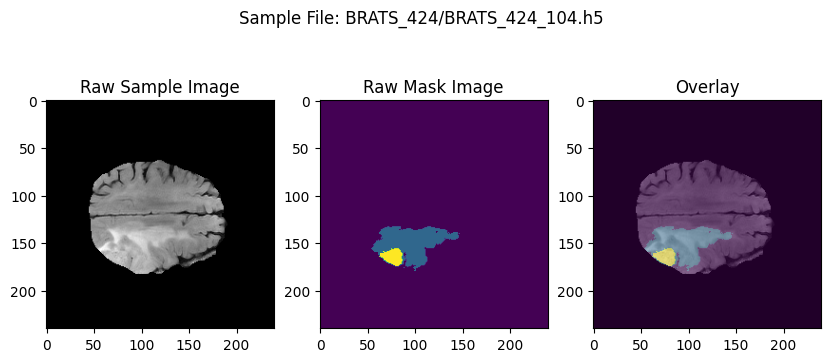

In [5]:
def first_glance_analysis(sample_path: str = None):
  """
    Parameters:
      - sample_path (str): path of a specific file (random - if not provided)
    Objectives:
      1) Choosing a random brats folder, and a random file from that folder
      2) Investigating the dataset contents {x: slice image array , y: mask array}
      3) Investigating Images/Masks seperately
      4) Investigating the color channels in our masks
      5) Drawing plots of our sample image, sample mask, and their overlay
  """
  # 1:
  if not sample_path:
    sample_folder = random.choice(os.listdir())
    sample_file = random.choice(os.listdir(sample_folder))
    sample_path = os.path.join(sample_folder,sample_file)
  print(f"Chosen Sample from All H5 Files: {sample_path}\n")

  # 2:
  with h5py.File(sample_path , 'r') as f:
    print(f'HDF5 dataset contents:')
    for dataset_name in f:
      dataset = f[dataset_name]
      print(dataset)
      sample_img_array = np.array(f.get('x'))
      sample_mask_array = np.array(f.get('y'))
      sample_mask_unique = np.unique(sample_mask_array)

  # 3:
  print(f'\nHDF5 Dataset Investigation:\n')
  print(f'Sample Image Array:\n{sample_img_array}\n')
  print(f'Sample Image Shape:\n{sample_img_array.shape}\n')
  print(f'Sample Mask Array:\n{sample_mask_array}\n')
  print(f'Sample Mask Shape:\n{sample_mask_array.shape}\n')

  # 4:
  print(f'Unique Values in Masks:\n{sample_mask_unique}\n')

  # 5:
  fig,axes = plt.subplots(1,3,figsize = (10,10))
  fig.suptitle(f'Sample File: {sample_path}',  y=0.7)
  axes[0].imshow(sample_img_array,cmap = 'gray')
  axes[0].set_title(f'Raw Sample Image')
  axes[1].imshow(sample_mask_array)
  axes[1].set_title(f'Raw Mask Image')
  axes[2].imshow(sample_img_array, cmap = 'gray')
  axes[2].imshow(sample_mask_array, alpha = 0.5)
  axes[2].set_title(f'Overlay')

first_glance_analysis()



---



**Part 2.2: Creating Primary Frame**

We have learned some useful info about few samples of our dataset:


1.   HDF5 files include x (img array) and y (mask array)

2.   Sample image/mask size is (240,240)

3.   There are four unique values in our mask array which is probably the number of different colors we have in our mask.






    
Now it's time to gather all our data in a strutured format!
Our purpose in these few steps is to gather the entire dataset into a primary frame, conduct some analysis, modify our frame, and finalize it.

In [6]:
@determinate
def primary_frame():
  """
    Objectives:
      1) Reading all images/masks from datasets
      2) Creating seperate lists for paths, patients, images and masks
      3) Creating our primary frame
    Returns:
      - Data frame (pandas.dataframe)
  """
  path = []
  patient_column = []
  image_column = []
  mask_column = []
  img_mask_paths = []

  # 1:
  for patient in os.listdir():
    img_mask_paths += (glob.glob(os.path.join(patient,"*h5")))

  # 2:
  for img_mask_path in sorted(img_mask_paths):
    patient_column.append(img_mask_path.split('/')[0])
    with h5py.File((img_mask_path) , 'r') as f:
      image_column.append(np.array(f.get('x')))
      mask_column.append(np.array(f.get('y')))
      path.append(img_mask_path)

  # 3:
  return (pd.DataFrame({'Patient': patient_column,'Path':path,
                           'Image': image_column, 'Mask': mask_column }))

P_frame = primary_frame()
P_frame.head()

,Patient,Path,Image,Mask
0,BRATS_001,BRATS_001/BRATS_001_60.h5,"[[-0.407894264289217, -0.407894264289217, -0.4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,BRATS_001,BRATS_001/BRATS_001_61.h5,"[[-0.407894264289217, -0.407894264289217, -0.4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,BRATS_001,BRATS_001/BRATS_001_62.h5,"[[-0.407894264289217, -0.407894264289217, -0.4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,BRATS_001,BRATS_001/BRATS_001_63.h5,"[[-0.407894264289217, -0.407894264289217, -0.4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,BRATS_001,BRATS_001/BRATS_001_64.h5,"[[-0.407894264289217, -0.407894264289217, -0.4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."




---




**Part 2.3: Exploratory Data Analysis (EDA)**

After forming our primary frame, It's better to investigate deeper into the data.
Our investigation here includes:


*   More info about our unique patients
*   More info about our duplicated files
*   More info about the shape/dim of our images
*   More info about the shape/dim of our masks
*   More info about the number of unique color values in our masks


In [7]:

class analysis ():

  def patient_analysis(df):
    """
      Parameters:
        - df (pandas.dataframe)
      Objectives:
        1) Providing info about number of unique patients
        2) Providing info about number of all slices
        3) Providing info about max/min number of slices per patient
    """
    unique_patients , counts = np.unique(df['Patient'],return_counts = True)
    # 1:
    print(f"Number of Unique Patients: {len(unique_patients)}")

    # 2:
    print(f"Number of All Slices: {len(df['Path'])}")

    # 3:
    print(f"Max Number of Slices per Patient: {np.max(counts)}")
    print(f"Min Number of Slices per Patient: {np.min(counts)}\n")

  def no_duplicates_assertion(df):
    """
      Parameters:
        - df (pandas.dataframe)
      Objectives:
        1) Duplicate checking of "Path" data
        2) Duplicate checking of "Image" data
        3) Duplicate checking of "mask" data
    """
    # I apply hash coding to our images and masks to speed up the checking.
    def img_mask_hash (array):
      return hashlib.sha1(array).hexdigest()


    # Using try_except along with assertion helps to find duplicates.
    # 1:
    try:
      assert len(df['Path']) == len(df.drop_duplicates(['Path'])), \
      'We have duplicates in our Path column!'
    except AssertionError as e:
      print(f"Error: {e}")

    # 2:
    try:
      df['Hash_Img'] = df["Image"].apply(img_mask_hash)
      assert len(df['Hash_Img']) == len(df.drop_duplicates(['Hash_Img'])), \
      'We have duplicates in our Image column!'
    except AssertionError as e:
      print(f"Error: {e}")

    # 3:
    try:
      df['Hash_Mask'] = df["Mask"].apply(img_mask_hash)
      assert len(df['Hash_Mask']) == len(df.drop_duplicates(['Hash_Mask'])), \
      'We have duplicates in our Mask column!'
    except AssertionError as e:
      print(f"Error: {e}")


  def correspondence_assertion(df):
    """
      Parameters:
        - df (pandas.dataframe)
      Objectives:
        1) Checking that every slice has it's corresponding data
    """
    # 1:
    assert len(df["Image"]) == len(df["Mask"]) == len(df["Path"]) == len(df["Patient"]), \
    'Number of images/masks/paths/patients do not match!'

  def plots (df):
    """
      Parameters:
        - df (pandas.dataframe)
      Objectives:
        1) Plotting Image Shapes Diversity
        2) Plotting Image Dimensions Diversity
        3) Plotting Mask Shapes Diversity
        4) Plotting Mask Dimensions Diversity
        5) Plotting Number of Slices per Patient
        6) Plotting Mask Color Distinct Values
    """
    image_shapes = [(image.shape[0],image.shape[1]) for image in df['Image']]
    image_dims = [len(image.shape) for image in df['Image']]
    image_shapes_set = set(image_shapes)
    unique_img_rows = [shape[0] for shape in image_shapes_set]
    unique_img_columns = [shape[1] for shape in image_shapes_set]

    mask_shapes = [(mask.shape[0],mask.shape[1]) for mask in df['Mask']]
    mask_dims = [len(mask.shape) for mask in df['Mask']]
    mask_shapes_set = set(mask_shapes)
    unique_mask_rows = [shape[0] for shape in mask_shapes_set]
    unique_mask_columns = [shape[1] for shape in mask_shapes_set]

    unique_patients , counts = np.unique(df['Patient'],return_counts = True)


    mask_unique_values = [np.unique(mask) for mask in df['Mask']]

    fig,axes = plt.subplots(2,3,figsize = (15,15))
    plt.subplots_adjust(left=0.01, right=2, bottom=0.2, top=0.8)

    # 1:
    axes[0,0].scatter(unique_img_rows,unique_img_columns)
    axes[0,0].set_title("Image Shapes Diversity")
    axes[0,0].set_xlabel('Img Heights (Pixels)')
    axes[0,0].set_ylabel('Img Widths (Pixels)')

    # 2:
    axes[1,0].hist(image_dims)
    axes[1,0].set_title('Img Dimensions Diversity')
    axes[1,0].set_xlabel('Number of Dimensions')
    axes[1,0].set_ylabel('Number of Images')

    # 3:
    axes[0,1].scatter(unique_mask_rows,unique_mask_columns)
    axes[0,1].set_title("Mask Shapes Diversity")
    axes[0,1].set_xlabel('Mask Heights (Pixels)')
    axes[0,1].set_ylabel('Mask Widths (Pixels)')

    # 4:
    axes[1,1].hist(mask_dims)
    axes[1,1].set_title('Mask Dimension Diversity')
    axes[1,1].set_xlabel('Number of Dimensions')
    axes[1,1].set_ylabel('Number of Masks')

    # 5:
    axes[0,-1].hist(counts,bins=100)
    axes[0,-1].set_title("Slices per Patient")
    axes[0,-1].set_xlabel('Number of Images per Patient')
    axes[0,-1].set_ylabel('Number of Patients')

    # 6:
    axes[-1,-1].hist(mask_unique_values)
    axes[-1,-1].set_title('Mask_Color_Diversity')
    axes[-1,-1].set_xlabel('Color Values')
    axes[-1,-1].set_ylabel('Number of Masks')

analysis.patient_analysis(P_frame)
analysis.no_duplicates_assertion(P_frame)
analysis.correspondence_assertion(P_frame)

Number of Unique Patients: 152
Number of All Slices: 4715
Max Number of Slices per Patient: 60
Min Number of Slices per Patient: 1

Error: We have duplicates in our Mask column!




---



As we see here, There are some identical mask arrays that need to be removed.So we will drop these data, and perform our EDA, again (including plots this time).

Number of Unique Patients: 149
Number of All Slices: 4495
Max Number of Slices per Patient: 60
Min Number of Slices per Patient: 1



,Patient,Path,Image,Mask
0,BRATS_001,BRATS_001/BRATS_001_60.h5,"[[-0.407894264289217, -0.407894264289217, -0.4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,BRATS_001,BRATS_001/BRATS_001_61.h5,"[[-0.407894264289217, -0.407894264289217, -0.4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,BRATS_001,BRATS_001/BRATS_001_62.h5,"[[-0.407894264289217, -0.407894264289217, -0.4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,BRATS_001,BRATS_001/BRATS_001_63.h5,"[[-0.407894264289217, -0.407894264289217, -0.4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,BRATS_001,BRATS_001/BRATS_001_64.h5,"[[-0.407894264289217, -0.407894264289217, -0.4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


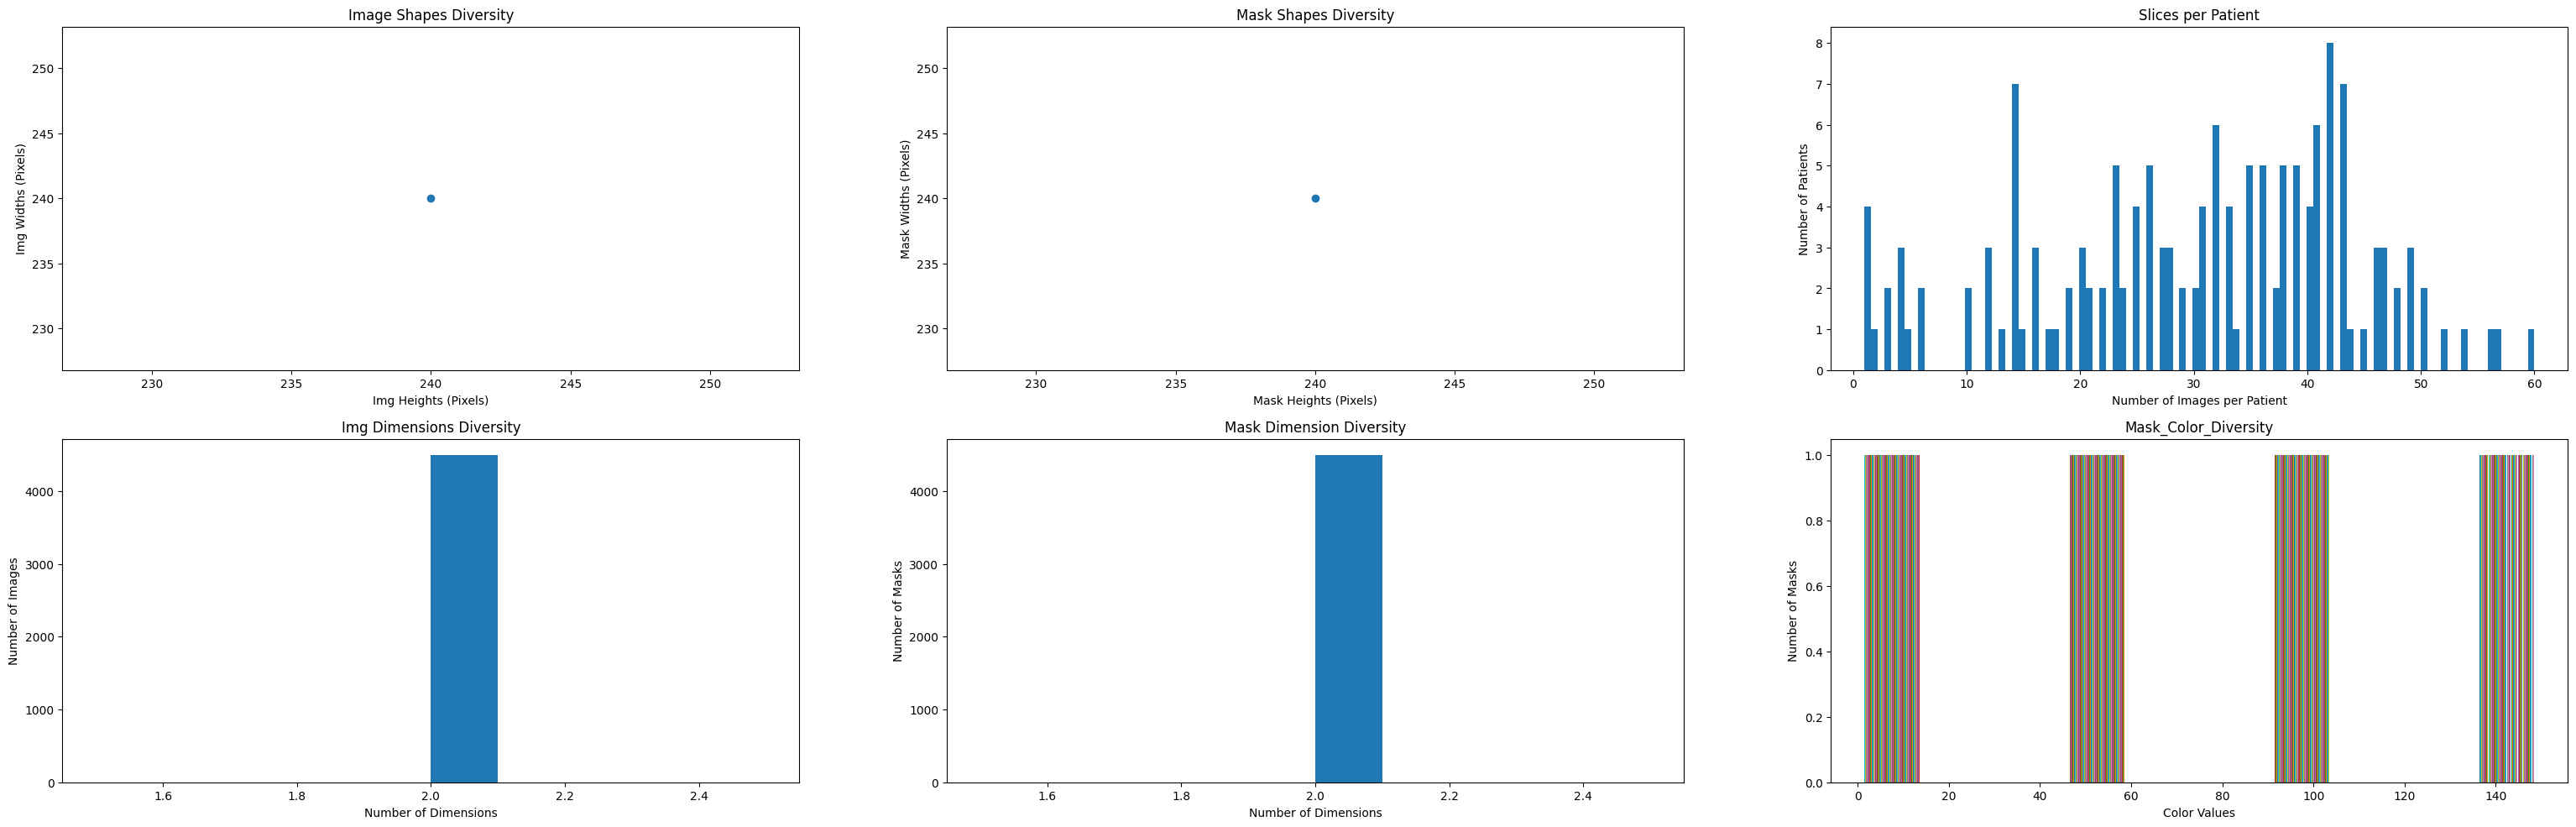

In [8]:
P_frame = P_frame.drop_duplicates(['Hash_Mask'])

# "Reset_Index" is an essential step after dropping some data from our frame!
P_frame = P_frame.reset_index(drop=True)

# Doing another set of analysis to make sure everything is going smoothly.
analysis.patient_analysis(P_frame)
analysis.no_duplicates_assertion(P_frame)
analysis.correspondence_assertion(P_frame)
analysis.plots(P_frame)

# No need of "Hash_Codings" after locating duplicates!
P_frame = P_frame.drop(["Hash_Mask","Hash_Img"], axis=1)
P_frame.head()



---



**Part 2.4: Mask Modifications**


As mentioned before, in this project we want to implement binary segmentation.
For this purpose, we need to have 2 classes (color channels here):

1.   Class 0 for background (Non_Mask_Areas)
2.   Class 1 for mask areas


As we saw before, there are 4 distinct color values in our masks:
(0,50,100,150)

Since 0 belongs to Non_Mask_Areas, it would be better to set the cut-off at 50.
By doing so, We can have the whole volume of our mask segment as class 1!

After preparing our binary masks, it's necessary to calculate mask volume for
each record in our dataset. It's one of the main factors that should be distributed equally among different datasets (train,test).

When the Mask_Area column is added, we shouldn't miss the chance to analyze it!

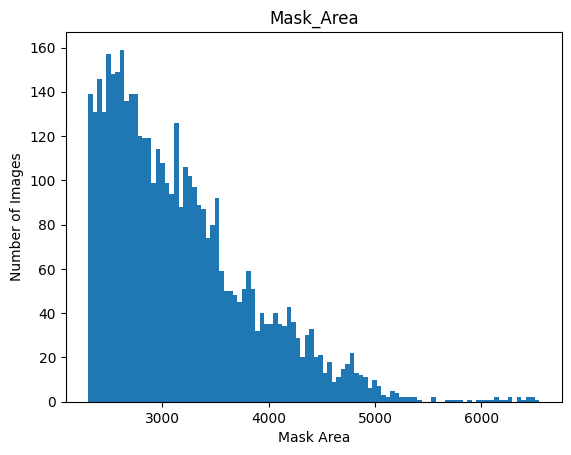

In [9]:
@determinate
def binary_masks(df):
  """
    Parameters:
      - df (pandas.dataframe)
    Objectives:
      1) Creating a "Binary_Mask" column in our primary frame
      2) Creating a "Mask_Area" column in our primary frame
      3) Drawing a histogram that shows the frequency of mask volumes
  """
  # 1:
  df['Binary_Mask'] = df['Mask'].apply(
      np.vectorize(lambda x: 1 if x >= 50 else 0))

  # 2:
  df["Mask_Area"] = [np.sum(mask) for mask  in df["Binary_Mask"]]

  # 3:
  plt.hist(df["Mask_Area"] , bins = 100)
  plt.title('Mask_Area')
  plt.xlabel("Mask Area")
  plt.ylabel("Number of Images")

binary_masks(P_frame)



---



Now that we have our correct forms of images/masks, It's not bad to visualize some of the samples to evaluate what we have done so far.

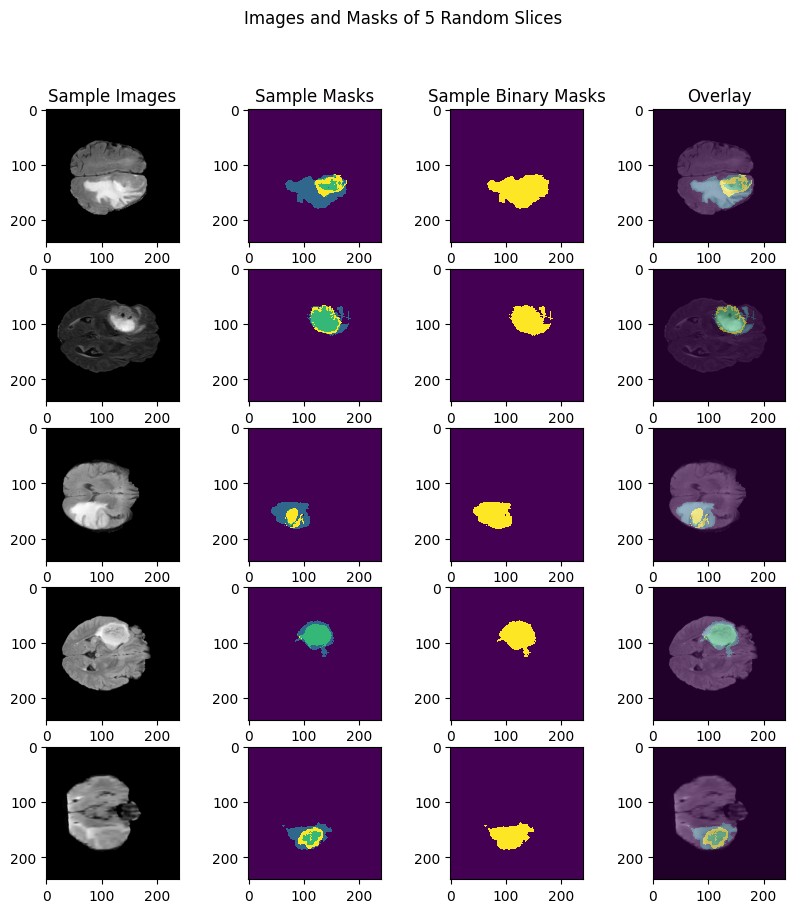

In [10]:
def plot_sample_frame(df):
  """
    Parameters:
      - df (pandas.dataframe)
    Objectives:
      1) Plot Sample Image
      2) Plot Sample Mask
      3) Plot Sample Binary Mask
      4) Plot Overlay
  """
  random_rows = df.sample(5).reset_index(drop = True)
  fig, axes = plt.subplots(5,4,figsize = (10,10))
  for i,row in random_rows.iterrows():
    fig.suptitle("Images and Masks of 5 Random Slices")
    # 1:
    axes[i,0].imshow(row['Image'], cmap = 'gray')
    axes[0,0].set_title("Sample Images")

    # 2:
    axes[i,1].imshow(row['Mask'], interpolation='nearest')
    axes[0,1].set_title("Sample Masks")

    # 3:
    axes[i,2].imshow(row['Binary_Mask'], interpolation='nearest')
    axes[0,2].set_title("Sample Binary Masks")

    # 4:
    axes[i,3].imshow(row['Image'], cmap = 'gray')
    axes[i,3].imshow(row['Mask'], interpolation='nearest', alpha = 0.5)
    axes[0,3].set_title("Overlay")


plot_sample_frame(P_frame)



---



**Part 2.5: Splitting data and Finalizing the Frame**

Now it's time to perform our last and, at the same time, our most important modification to our data frame.

In the previous section, we observed a significant variance in the distribution of mask volumes. This variable plays a crucial role in our training process and can potentially introduce several issues such as biases. Therefore, we are left with no alternative but to split our data based on this factor to ensure that our train, validation, and test sets exhibit a similar distribution of mask areas.

StratifiedGroupKFold from scikit-learn allows us to achieve this. However, since it only works on categorical variables, we need to convert the volumes into 10 equal partitions. After that, we can use the Kfold technique to randomly assign 10% of our data to the test set, 10% to our the validation set, and 80% to the training set while ensuring that no same patient is repeated in our sets and that the areas are distributed equally among them. After the split, it is advisable to check the number of duplicates in our groups and also the distribution of mask volumes.


Training Set Size: 3609
Validation Set Size: 515
Test Set Size: 371


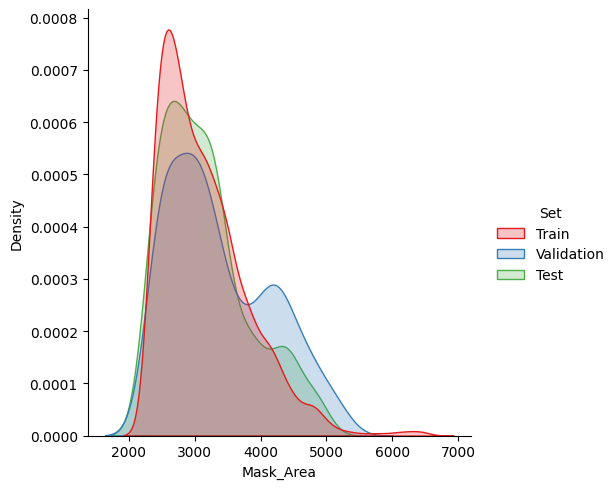

In [11]:
@determinate
class split_frame():

  @determinate
  def split(df):
    """
      Parameters:
        - df (pandas.dataframe)
      Objectives:
        1) Dividing the data into 10 equal bins, based on "Mask_Area" column
        2) Spliting our data to train/validation/test sets based on ["Patient"]
        and stratified by ["Mask_Area"]
        3) Returning sizes of all three sets
        4) Checking if no patient is in the three sets at the same time
        5) Plotting the distribution plot of mask volumes based on our sets
    """
    # 1:
    df["Mask_Area_Bin"] = pd.cut(df['Mask_Area'], bins=10).astype(str)

    # 2:
    sp = StratifiedGroupKFold(n_splits = 10, shuffle = True)
    for fold, (train_index,test_index) in enumerate(sp.split(
        df, y = df['Mask_Area_Bin'], groups = df['Patient'])):
      if fold < 8:
        df.loc[test_index, 'Fold'] = fold + 1
        df.loc[test_index, 'Set'] = 'Train'
      elif fold == 8:
        df.loc[test_index, 'Fold'] = fold + 1
        df.loc[test_index, 'Set'] = 'Validation'
      else:
        df.loc[test_index, 'Fold'] = fold + 1
        df.loc[test_index, 'Set'] = 'Test'

    Train_Set_Size = len(df[df["Set"]=="Train"])
    Validation_Set_Size = len(df[df["Set"]=="Validation"])
    Test_Set_Size = len(df[df["Set"]=="Test"])

    # 3:
    print(f"Training Set Size: {Train_Set_Size}")
    print(f"Validation Set Size: {Validation_Set_Size}")
    print(f"Test Set Size: {Test_Set_Size}")

  # 4:
  @determinate
  def no_dup_assertion(df):
    """
      Parameters:
        - df (pandas.dataframe)
      Objectives:
        1) No duplicated patient in train/test sets assertion
        2) No duplicated patient in train/validation sets assertion
        3) No duplicated patient in validation/test sets assertion
    """
    assert len(set(df[df['Set'] == 'Train']['Patient']).intersection(
        set(df[df['Set'] == 'Test']['Patient']))) == 0, \
        'Some patients are in both the train and test sets!'

    assert len(set(df[df['Set'] == 'Train']['Patient']).intersection(
        set(df[df['Set'] == 'Validation']['Patient']))) == 0, \
        'Some patients are in both the train and validation sets!'

    assert len(set(df[df['Set'] == 'Test']['Patient']).intersection(
        set(df[df['Set'] == 'Validation']['Patient']))) == 0, \
        'Some patients are in both the test and validation sets!'

  # 5:
  @determinate
  def plot_train_test(df):
    """
      Parameters:
        - df (pandas.dataframe)
      Objectives:
        - plotting the Mask Area distribution plot among three sets
    """
    sns.displot(df, x='Mask_Area', hue='Set', kind='kde', fill=True, common_norm=False, palette='Set1')


split_frame.split(P_frame)
split_frame.no_dup_assertion(P_frame)
split_frame.plot_train_test(P_frame)



---



**Part 2.6: Creating Train/Val/Test lists**

After finalizing our data frame, it's time to create
our train, validation, and test lists to prepare them for our dataloaders!



In [12]:
@determinate
def list_of_records(df) -> List:
  """
    Parameters:
      - df (pandas.dataframe)
    Objectives:
      1) Creating Train_List: List of dictionary records for each training data
      2) Creating Val_List: List of dictionary records for each validation data
      3) Creating Test_List: List of dictionary records for each test data
      4) Showing the first record of every list + length of each of them
    Returns:
      - Train_list
      - Val_list
      - Test_list
  """
  # 1:
  Train_List = df[df["Set"]=="Train"].to_dict("records")
  random.shuffle(Train_List)

  # 2:
  Val_List = df[df["Set"]=="Validation"].to_dict("records")
  random.shuffle(Val_List)

  # 3:
  Test_List = df[df["Set"]=="Test"].to_dict("records")
  random.shuffle(Test_List)

  # 4:
  print(f"First Record of Our Training List (Full Length: {len(Train_List)}):\n")
  print(Train_List[0])

  print(f"\nFirst Record of Our Validation List (Full Length: {len(Val_List)}):\n")
  print(Val_List[0])

  print(f"\nFirst Record of Our Test List (Full Length {len(Test_List)}):\n")
  print(Test_List[0])

  return(Train_List, Val_List, Test_List)

Train_List, Val_List, Test_List = list_of_records(P_frame)

First Record of Our Training List (Full Length: 3609):

{'Patient': 'BRATS_347', 'Path': 'BRATS_347/BRATS_347_101.h5', 'Image': array([[-0.4522199, -0.4522199, -0.4522199, ..., -0.4522199, -0.4522199,
        -0.4522199],
       [-0.4522199, -0.4522199, -0.4522199, ..., -0.4522199, -0.4522199,
        -0.4522199],
       [-0.4522199, -0.4522199, -0.4522199, ..., -0.4522199, -0.4522199,
        -0.4522199],
       ...,
       [-0.4522199, -0.4522199, -0.4522199, ..., -0.4522199, -0.4522199,
        -0.4522199],
       [-0.4522199, -0.4522199, -0.4522199, ..., -0.4522199, -0.4522199,
        -0.4522199],
       [-0.4522199, -0.4522199, -0.4522199, ..., -0.4522199, -0.4522199,
        -0.4522199]]), 'Mask': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'Binary_Mask': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ...



---



**Part 2.7: Building Data Loaders**

We have our train, validation, and test lists fully prepared. So everything is ready
to build our data loaders required for training.

Note:

In this project, I'm using MONAI transforms, datasets, and data loaders, since
their advantages in working with big data has been proved (especially in medical field).


So first of all, we need to prepare our transforms. There are some required transforms for our dataset
(and most of the available datasets), along with some optional transforms mostly used for augmentations.

As we know, We are only allowed to use augmentations on our training dataset to increase the model generalization.
So here, we define two sets of transforms (train and test). After that, we use MONAI persistent datasets to use the advantages of them
(space efficiency, disk caching, etc.)


Last step here is to build our data loaders which is not that hard thanks to MONAI and PyTorch!


Notes:

*   Since I'm using free plan of google colab, There is a limited version of GPU accessible. So I decide to reshape our data from (240,240) to (128,128) to save a lot of our computational power!

*   I'm using 4 worker processes to load the data in parallel, and the batch size of 8 is suitable.



In [13]:
@determinate
def build_loader(Train_List: list = Train_List,
                 Val_List: list = Val_List,
                 Test_List: list = Test_List,
                 Original_Size: int = 240,
                 Target_Size: int = 128,
                 Train_Augmentation: bool = True
                 ) -> DataLoader:
  """
    Parameters:
      - Train_List (list): List of our training data
      - Val_List (list): List of our validation data
      - Test_List (list): List of our Test data
      - Original_size (int): Original Size of our images/masks
      - Target_size (int): Modified size of our images/masks
      - Train_Augmentation (bool): Default -> False
    Objectives:
      1) Setting MONAI transforms
      2) Building MONAI datasets
      3) Building MONAI dataloaders
    Returns:
      - Train Dataloader
      - Valid Dataloader
      - Test Dataloader
  """
  target_size = (Target_Size,Target_Size)

  # 1:
  aug_transforms = mn.transforms.Compose([
    mn.transforms.EnsureChannelFirstd(keys=['Image', 'Binary_Mask'], channel_dim="no_channel"),
    mn.transforms.Transposed(keys=['Image', 'Binary_Mask'], indices=[0, 2, 1]),
    mn.transforms.RandRotated(keys=['Image', 'Binary_Mask'], range_x=(0.7), prob=0.3, mode=('bilinear', 'nearest')),
    mn.transforms.RandFlipd(keys=['Image', 'Binary_Mask'], spatial_axis=1, prob=0.5),
    mn.transforms.RandZoomd(keys=['Image', 'Binary_Mask'], prob=0.5, mode=('bilinear', 'nearest')),
    mn.transforms.Resized(keys=['Image', 'Binary_Mask'], spatial_size=target_size, mode=('bilinear', 'nearest')),
    mn.transforms.ScaleIntensityd(keys=['Image'], minv=0, maxv=1),
    mn.transforms.ToTensord(keys=['Image', 'Binary_Mask'])
  ])

  no_aug_transforms = mn.transforms.Compose([
    mn.transforms.EnsureChannelFirstd(keys=['Image', 'Binary_Mask'], channel_dim="no_channel"),
    mn.transforms.Transposed(keys=['Image', 'Binary_Mask'], indices=[0, 2, 1]),
    mn.transforms.Resized(keys=['Image', 'Binary_Mask'], spatial_size=target_size, mode=('bilinear', 'nearest')),
    mn.transforms.ScaleIntensityd(keys=['Image'], minv=0, maxv=1),
    mn.transforms.ToTensord(keys=['Image', 'Binary_Mask'])

  ])
  # Prepare to cache the transformed data in order to reduce processing time!
  shutil.rmtree('Cache', ignore_errors=True)

  # 2:
  if Train_Augmentation:
    Train_Dataset = mn.data.dataset.PersistentDataset(data = Train_List, transform= aug_transforms, cache_dir='Cache/Train')
  else:
    Train_Dataset = mn.data.dataset.PersistentDataset(data = Train_List, transform= no_aug_transforms, cache_dir='Cache/Train')
  Valid_Dataset = mn.data.dataset.PersistentDataset(data = Val_List, transform= no_aug_transforms, cache_dir='Cache/Test')
  Test_Dataset = mn.data.dataset.PersistentDataset(data = Test_List, transform = no_aug_transforms, cache_dir= 'Cache/Test')

  # 3:
  Train_Dataloader = mn.data.DataLoader(Train_Dataset, batch_size=8, shuffle=True, num_workers=4)
  Valid_Dataloader = mn.data.DataLoader(Valid_Dataset, batch_size=8, shuffle=False, num_workers=4)
  Test_Dataloader = mn.data.DataLoader(Test_Dataset, batch_size=8 , shuffle=False, num_workers=4)

  return(Train_Dataloader, Valid_Dataloader, Test_Dataloader)


Train_Dataloader, Valid_Dataloader, Test_Dataloader = build_loader()

Since data loaders can be considered one of the most crucial components of our
torch-based training programs, let's evaluate their contents quickly before going further!

Image Shapes: torch.Size([1, 128, 128])
Image Types: torch.float32
Mask Shapes: torch.Size([1, 128, 128])
Mask Types: torch.float32


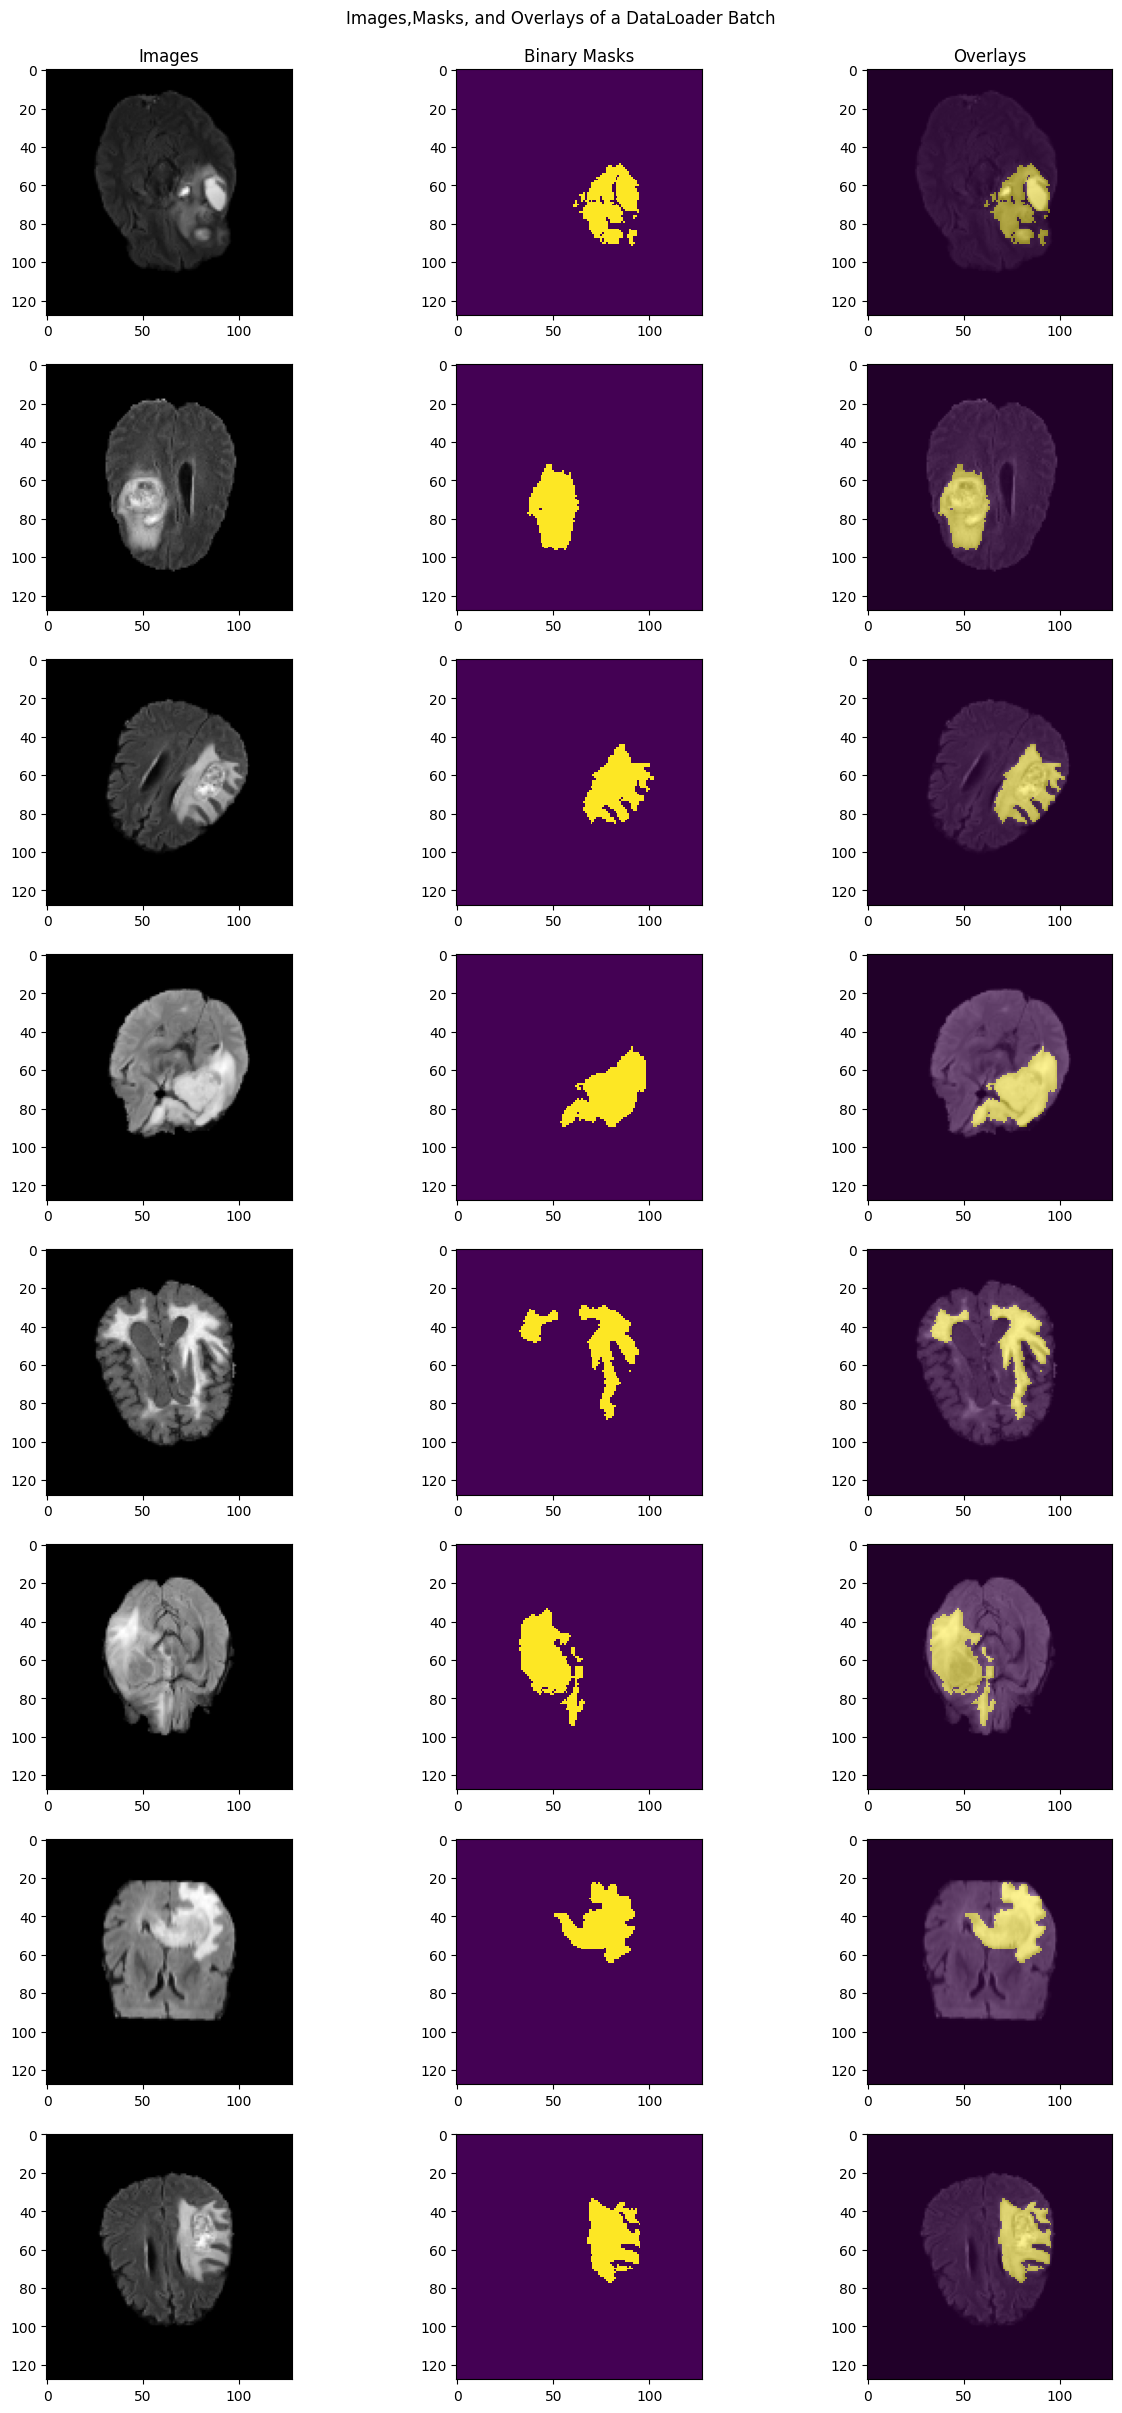

In [14]:
def eval_sample_loader(Dataloader: DataLoader = Train_Dataloader):
  """
    parameters:
      - Dataloader (DataLoader)
    Objectives:
      1) Presenting images/masks shapes and types in data loader
      2) Plotting Images, Binary Masks, and Their overlay in seperate columns
  """
  # 1:
  batch = next(iter(Dataloader))
  print(f"Image Shapes: {batch['Image'][0].shape}")
  print(f"Image Types: {batch['Image'].dtype}")
  print(f"Mask Shapes: {batch['Binary_Mask'][0].shape}")
  print(f"Mask Types: {batch['Image'].dtype}")

  # 2:
  fig, axes = plt.subplots(8, 3, figsize=(15, 30))
  fig.suptitle(f"Images,Masks, and Overlays of a DataLoader Batch", y=0.9)

  axes[0, 0].set_title("Images")
  axes[0,1].set_title("Binary Masks")
  axes[0,2].set_title("Overlays")

  for i in range(8):
    axes[i, 0].imshow(batch['Image'][i][0], cmap='gray')
    axes[i, 1].imshow(batch['Binary_Mask'][i][0],interpolation='nearest')
    axes[i, 2].imshow(batch['Image'][i][0], cmap='gray')
    axes[i, 2].imshow(batch['Binary_Mask'][i][0], interpolation='nearest', alpha=0.5)

eval_sample_loader()



---



# **Part 3: Loading the Model's Architecture**

Now it's time to choose a proper architecture for our task in hand.
U_Nets structures, consisting of encoder and decoder parts, are commonly used for segmentation tasks.

Thanks to MONAI, We have access to many pre-designed architectures including U_Nets.

Here, We try FlexibleUNet in which the backbone/encoder can be replaced with any efficient network.
The backbone only supports networks from efficientnet family. for this task which presumably is not that hard,
The simplest form (b0) is prefered.

If we set the "pretrained" to "True" (default: False), we initialize pretrained ImageNet weights for our task (which makes it a lot easier to train it!)



*   Since the pre-trained weights were obtained from a classification task, during the pre-training evaluation step, we initialize the model with random weights to demonstrate random results more effectively.


In [15]:
flex_untrained = mn.networks.nets.FlexibleUNet(
    in_channels=1,
    out_channels=2,
    backbone='efficientnet-b0',
    pretrained=False
)

flex_untrained = flex_untrained.to(device)

# Never forget to check the summary of your model before going deeper!
summary(flex_untrained)

Layer (type:depth-idx)                                  Param #
FlexibleUNet                                            --
├─EfficientNetEncoder: 1-1                              --
│    └─Conv2d: 2-1                                      288
│    └─ConstantPad2d: 2-2                               --
│    └─BatchNorm2d: 2-3                                 64
│    └─Sequential: 2-4                                  --
│    │    └─Sequential: 3-1                             1,448
│    │    └─Sequential: 3-2                             16,714
│    │    └─Sequential: 3-3                             46,640
│    │    └─Sequential: 3-4                             242,930
│    │    └─Sequential: 3-5                             543,148
│    │    └─Sequential: 3-6                             2,026,348
│    │    └─Sequential: 3-7                             717,232
│    └─Conv2d: 2-5                                      409,600
│    └─Identity: 2-6                                    --
│    └─Batch



---



# **Part 4: Training the Model for Locating ROI**

**Part 4.1: Defining A Metric Function**

Before defining the training function, it's recommended to define our loss function and metric to improve consistency and clarity in the training process.

For segmentation tasks, the Dice Coefficient (Dice metric) is one of the best choices we have.
This similarity measure is used to calculate the spatial overlap between two sets.



Thanks to MONAI, we have access to a great dice coefficient metric, optimized for calculating the dice of each prediction in our batch, returning a list including a dice metric for each segmented class we have (here: a list of two dice values (classes = 2))


MONAI Dice necessitates us to provide softmaxed one-hot coded forms of outputs for it. So we need to do these conversions on our own.

Thankfully, our mask data only requires one-hot coding, but we should perform the conversions for our predictions!

In [16]:
def mnDice(pred,target):
  """
    Parameters:
      - pred (torch.tensor)
      - target (torch.tensor)
    Returns:
      - metric_fn (function)
  """
  pred = torch.softmax(pred, dim=1)
  pred = torch.argmax(pred, dim=1, keepdim=True).float()
  onehot_pred = mn.networks.utils.one_hot(pred, num_classes=2)
  onehot_target = mn.networks.utils.one_hot(target, num_classes=2)
  metric_fn = mn.metrics.DiceMetric(include_background=True)

  return (metric_fn(onehot_pred,onehot_target))


**Part 4.2: Defining A Loss Function**

Next, we are going for the loss function. We have seen the advantages of the Dice Coefficient in the previous section. Now, MONAI provides us a powerful loss function combining CrossEntropy and Dice to use the advantages of both of them, at the same time.

By using softmax = True, there is no need to add any additional conversions, neither for predictions nor for targets!

In [17]:
def CEDice(pred,target):
  """
    Parameters:
      - pred (torch.tensor)
      - target (torch.tensor)
    Returns:
      - loss (function)
  """
  loss_fn = mn.losses.DiceCELoss(include_background=True, to_onehot_y=True, sigmoid=False, softmax=True)

  return(loss_fn(pred, target))

**Part 4.3: Evaluating the Untrained Model's Performance to Determine Our Baseline**


At the moment, we have a simple (but efficient!) model with nearly 7mil parameters and pre-trained weights for the encoder part.
Here I want to define a useful function to plot the predictions of our model which we can use:

1.   Before any task-specific training (right now!), to show the extent to which models' predictions differ from the masks (defining a baseline)

2.   After training, to compare the prediction masks to the actual ones!


By looking the shape and the output of our model, we realize that it gives us 2 list of distinct numbers for our pixels. one set indicates class 0 and the other one indicates class 1.
so for plotting the mask, we should use argmax to choose the higher value between these two sets.

Here is the first output of this batch:

metatensor([[[ 0.0051,  0.0041,  0.0841,  ...,  0.0826,  0.2157,  0.0657],
         [ 0.2364, -0.0484,  0.0393,  ...,  0.0086,  0.1995, -0.1083],
         [ 0.3411, -0.0618, -0.0068,  ..., -0.2884,  0.0179, -0.2003],
         ...,
         [ 0.0605, -0.1007, -0.0791,  ...,  0.0787,  0.1504, -0.3864],
         [ 0.0326,  0.0574,  0.2102,  ..., -0.0179,  0.0624, -0.2799],
         [ 0.0960, -0.1530, -0.2436,  ..., -0.1225, -0.1937, -0.4525]],

        [[-0.3345, -0.3816, -0.2191,  ..., -0.2743, -0.3160, -0.1443],
         [-0.3915, -0.2520, -0.1061,  ..., -0.4153, -0.3806, -0.3183],
         [-0.4148, -0.1110,  0.0221,  ..., -0.2896, -0.3977, -0.1880],
         ...,
         [-0.4307, -0.2680, -0.1486,  ..., -0.2075, -0.3804, -0.2801],
         [-0.4792, -0.3115, -0.2581,  ..., -0.3964, -0.3412, -0.2070],
         [-0.4293, -0.4680, -0.5369,  ..., -0.3472, -0.2232, -0.3450]]],
       device='cuda:0', grad_fn=<AliasBackward0>) 

The dice coefficien

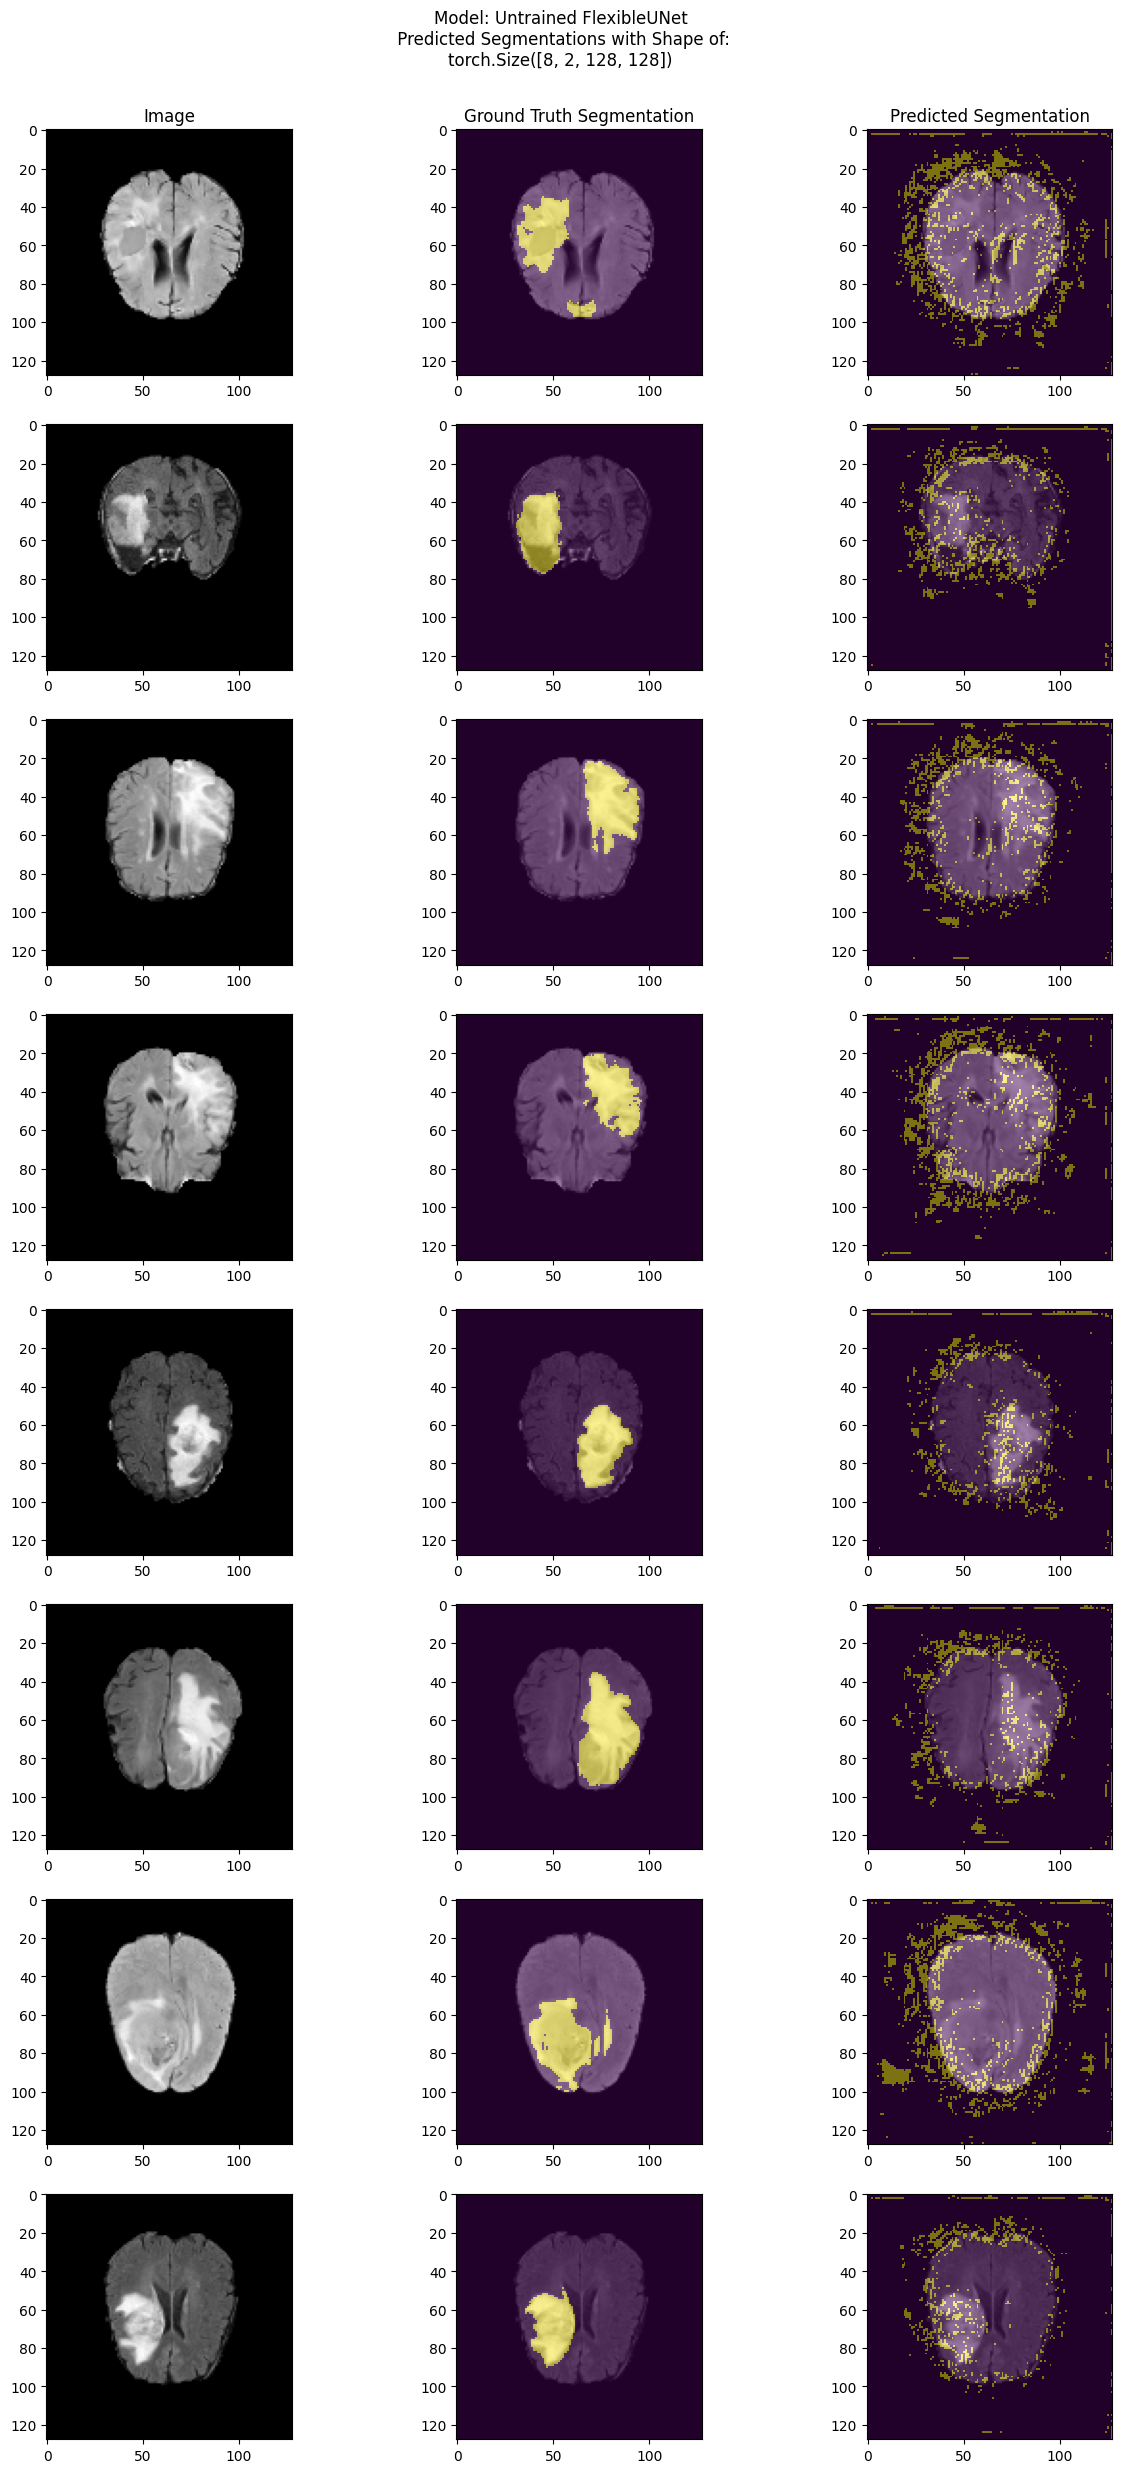

In [33]:
@determinate
def predictions(Model: torch.nn.Module,
                Model_Name: str,
                Dataloader: DataLoader):
  """
    Parameters:
      - Model (torch.nn.Module): Indicating a model to evaluate its predictions
      - Model_Name (str): Name of the model getting evaluated
      - Dataloader (DataLoader): Indicating a data loader to load images/masks

    Objectives:
      1) Getting the output of a sample batch
      2) Presenting one of the outputs
      3) Presenting the size of our model outputs
      4) Plotting Images / Masks / Predicted Masks for a batch in our data loader
      5) Presenting the dice values for the background and the mask area in each record
  """
  # 1:
  batch = next(iter(Dataloader))
  sample_imgs = batch['Image'].to(device)
  sample_masks = batch['Binary_Mask'].to(device)
  sample_preds = Model(sample_imgs)

  # 2:
  print("Here is the first output of this batch:\n")

  # 3:
  print(sample_preds[0],'\n')


  dice_list = mnDice(sample_preds, sample_masks).tolist()

  # 4:
  fig, axes = plt.subplots(8, 3, figsize=(15, 30))
  fig.suptitle(f"Model: {Model_Name}\n Predicted Segmentations with Shape of:\n{sample_preds.shape}", y=0.92)
  axes[0,0].set_title('Image')
  axes[0,1].set_title('Ground Truth Segmentation')
  axes[0,2].set_title('Predicted Segmentation')
  for i, (img, mask, pred) in enumerate(zip(sample_imgs, sample_masks, sample_preds)):
    axes[i, 0].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 1].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 1].imshow(mask[0].detach().cpu(),interpolation='nearest', alpha=0.5)
    axes[i, 2].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 2].imshow(pred.argmax(dim=0).detach().cpu(),interpolation='nearest', alpha=0.5)
    # 5:
    print(f"The dice coefficient of record {i+1} in this batch:")
    print(f"Background: {dice_list[i][0]:.4f}, Tumor: {dice_list[i][1]:.4f}\n")

predictions(Model = flex_untrained , Model_Name = "Untrained FlexibleUNet" , Dataloader = Test_Dataloader)



---



**Part 4.4: Building A Trainer**

Here we are at the training session! We prepared our dataloaders, loss and metric functions. The other arguments like optimizer or num_epochs will be determined for every model before training.


Our training function includes 2 main parts: training, and validation for each batch during epochs.


Don't forget to log the losses and metrics (for each batch and for each epoch).

It's always better to create a checkpoint system for saving the best model (weights)!

In [19]:
@determinate
def Train(model: torch.nn.Module,
          model_name: str,
          num_epochs: int,
          train_dataloader: Iterable,
          valid_dataloader: Iterable,
          loss_fn: Callable,
          optimizer: torch.optim,
          metric_fn: Callable
          ):

  # CPU will explode if we forget this line.
  model.to(device)

  # Since we are doing multiple training sessions, it's necessary to clean the cache here.
  with torch.no_grad():
    torch.cuda.empty_cache()


  all_train_losses = []
  all_valid_losses = []
  all_train_metrics = []
  all_valid_metrics = []

  best_valid_loss = None

  # Creating a path for our best version of our model.
  best_models_dir = os.path.join('Best_Models', model_name)
  if os.path.exists(best_models_dir):
    shutil.rmtree(best_models_dir)
  os.makedirs(best_models_dir, exist_ok=True)

  for epoch in range(num_epochs):
      print(f'Starting epoch {epoch+1}/{num_epochs}:')

      # Training loop

      epoch_train_loss = []
      epoch_train_metric = []

      model.train()
      for batch in tqdm(train_dataloader, desc='Training'):
          img = batch['Image'].to(device)
          target = batch['Binary_Mask'].to(device)

          optimizer.zero_grad()

          pred = model(img)
          loss = loss_fn (pred, target)
          loss.backward()
          optimizer.step()
          epoch_train_loss.append(loss.item())

          metric = metric_fn(pred,target)
          metric = torch.mean(metric)
          epoch_train_metric.append(metric.item())


      # Validation loop

      epoch_valid_loss = []
      epoch_valid_metric = []

      model.eval()
      for batch in tqdm(valid_dataloader, desc='Validation'):
          img = batch['Image'].to(device)
          target = batch['Binary_Mask'].to(device)

          # No Update During Validation!
          with torch.no_grad():
              pred = model(img)
              loss = loss_fn (pred, target)
              epoch_valid_loss.append(loss.item())

          metric = metric_fn(pred,target)
          metric = torch.mean(metric)
          epoch_valid_metric.append(metric.item())


      # Logging the epoch losses and metrics!
      epoch_train_loss = torch.mean(torch.tensor(epoch_train_loss))
      epoch_valid_loss = torch.mean(torch.tensor(epoch_valid_loss))
      epoch_train_metric = torch.mean(torch.tensor(epoch_train_metric))
      epoch_valid_metric = torch.mean(torch.tensor(epoch_valid_metric))
      all_train_losses.append(epoch_train_loss.item())
      print(f"\nepoch_train_loss: {epoch_train_loss.item()}")
      all_valid_losses.append(epoch_valid_loss.item())
      print(f"epoch_valid_loss: {epoch_valid_loss.item()}")
      all_train_metrics.append(epoch_train_metric.item())
      print(f"epoch_train_metric: {epoch_train_metric.item()}")
      all_valid_metrics.append(epoch_valid_metric.item())
      print(f"epoch_valid_metric: {epoch_valid_metric.item()}")

      # Saving the best model
      if best_valid_loss is None or epoch_valid_loss < best_valid_loss:
          best_valid_loss = epoch_valid_loss
          weight = f'{model_name}_Epoch{epoch+1}_Metric={epoch_valid_metric}.pth'
          torch.save(model.state_dict(), os.path.join(best_models_dir, weight))
          print('Saved best model!\n')

      print("*"*60)

  print(f'\nTrainng was over. The best model was: {weight}\n')

  # Loading the best weights into our model, inside our function !
  model.load_state_dict(torch.load(os.path.join(best_models_dir, weight)))

  # Evaluation plots:
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))
  axes[0].plot(all_train_losses, label='Training loss')
  axes[0].plot(all_valid_losses, label='Validation loss')
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[1].plot(all_train_metrics, label='Training dice')
  axes[1].plot(all_valid_metrics, label='Validation dice')
  axes[1].set_title('Dice')
  axes[1].legend()

  return model

**Part 4-5: Training a Model (UFlex)**

Our training function is ready! Since I like to see the real power of a pre-trained UNet, I load another UFlex with pretrain = "True" !

We will use this config for the following trainings:

*   Optimizer: torch.optim.AdamW
*   Number of Epochs: 15
*   Learning Rate: 1e-5








Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 70.5MB/s]


Starting epoch 1/15:


Validation: 100%|██████████| 65/65 [00:07<00:00,  9.18it/s]



epoch_train_loss: 0.8498418927192688
epoch_valid_loss: 1.0060621500015259
epoch_train_metric: 0.7764443159103394
epoch_valid_metric: 0.485144704580307
Saved best model!

************************************************************
Starting epoch 2/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 11.51it/s]



epoch_train_loss: 0.593989908695221
epoch_valid_loss: 0.5505858063697815
epoch_train_metric: 0.928778886795044
epoch_valid_metric: 0.922067403793335
Saved best model!

************************************************************
Starting epoch 3/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 11.83it/s]



epoch_train_loss: 0.4436821937561035
epoch_valid_loss: 0.3769235908985138
epoch_train_metric: 0.9438864588737488
epoch_valid_metric: 0.9493100643157959
Saved best model!

************************************************************
Starting epoch 4/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 11.90it/s]



epoch_train_loss: 0.33830535411834717
epoch_valid_loss: 0.2904892861843109
epoch_train_metric: 0.950380802154541
epoch_valid_metric: 0.9513928294181824
Saved best model!

************************************************************
Starting epoch 5/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 12.07it/s]



epoch_train_loss: 0.2622339129447937
epoch_valid_loss: 0.22798223793506622
epoch_train_metric: 0.9544300436973572
epoch_valid_metric: 0.9539744257926941
Saved best model!

************************************************************
Starting epoch 6/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 11.78it/s]



epoch_train_loss: 0.20694755017757416
epoch_valid_loss: 0.18236517906188965
epoch_train_metric: 0.957062304019928
epoch_valid_metric: 0.9574640989303589
Saved best model!

************************************************************
Starting epoch 7/15:


Validation: 100%|██████████| 65/65 [00:06<00:00,  9.97it/s]



epoch_train_loss: 0.16724590957164764
epoch_valid_loss: 0.15061812102794647
epoch_train_metric: 0.9593707919120789
epoch_valid_metric: 0.9582546949386597
Saved best model!

************************************************************
Starting epoch 8/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 11.64it/s]



epoch_train_loss: 0.13920606672763824
epoch_valid_loss: 0.13471104204654694
epoch_train_metric: 0.9608140587806702
epoch_valid_metric: 0.9560789465904236
Saved best model!

************************************************************
Starting epoch 9/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 12.01it/s]



epoch_train_loss: 0.11902223527431488
epoch_valid_loss: 0.11459134519100189
epoch_train_metric: 0.9619771838188171
epoch_valid_metric: 0.9582428336143494
Saved best model!

************************************************************
Starting epoch 10/15:


Validation: 100%|██████████| 65/65 [00:06<00:00, 10.28it/s]



epoch_train_loss: 0.10445486754179001
epoch_valid_loss: 0.1049385517835617
epoch_train_metric: 0.9628705978393555
epoch_valid_metric: 0.9584589004516602
Saved best model!

************************************************************
Starting epoch 11/15:


Validation: 100%|██████████| 65/65 [00:06<00:00, 10.18it/s]



epoch_train_loss: 0.09369953721761703
epoch_valid_loss: 0.09378904849290848
epoch_train_metric: 0.9635499119758606
epoch_valid_metric: 0.9607415199279785
Saved best model!

************************************************************
Starting epoch 12/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 11.18it/s]



epoch_train_loss: 0.08496725559234619
epoch_valid_loss: 0.08774161338806152
epoch_train_metric: 0.9645462036132812
epoch_valid_metric: 0.9609835147857666
Saved best model!

************************************************************
Starting epoch 13/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 12.16it/s]



epoch_train_loss: 0.07942301034927368
epoch_valid_loss: 0.08428926020860672
epoch_train_metric: 0.9646753072738647
epoch_valid_metric: 0.96027010679245
Saved best model!

************************************************************
Starting epoch 14/15:


Validation: 100%|██████████| 65/65 [00:06<00:00,  9.94it/s]



epoch_train_loss: 0.07394637167453766
epoch_valid_loss: 0.08128359168767929
epoch_train_metric: 0.9655390977859497
epoch_valid_metric: 0.9606740474700928
Saved best model!

************************************************************
Starting epoch 15/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 12.28it/s]



epoch_train_loss: 0.07020026445388794
epoch_valid_loss: 0.07921651750802994
epoch_train_metric: 0.9659861326217651
epoch_valid_metric: 0.9604565501213074
Saved best model!

************************************************************

Trainng was over. The best model was: U_Flex_Epoch15_Metric=0.9604565501213074.pth



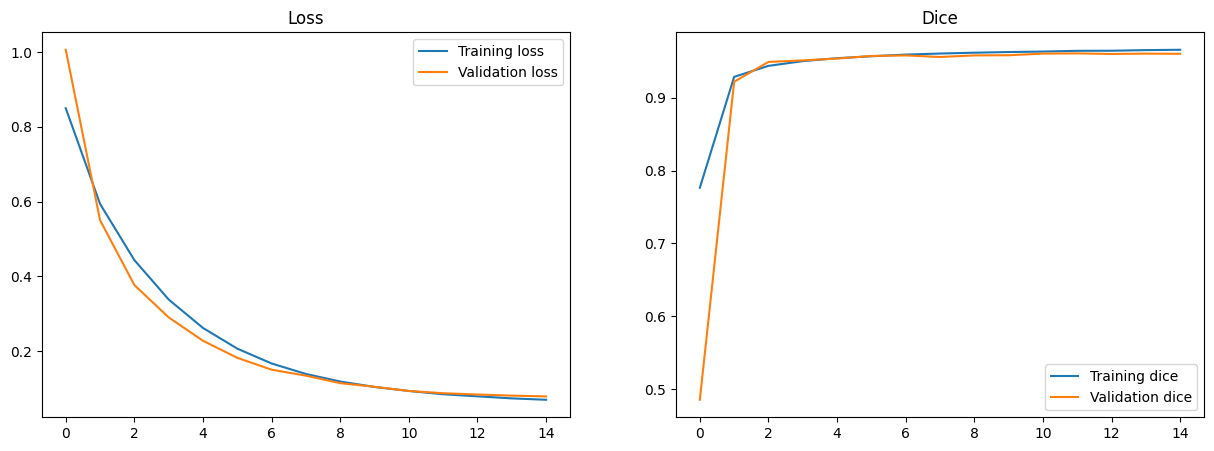

In [20]:
flex_pretrained = mn.networks.nets.FlexibleUNet(
    in_channels=1,
    out_channels=2,
    backbone='efficientnet-b0',
    pretrained=True
)
flex_pretrained = flex_pretrained.to(device)

num_epochs = 15
learning_rate = 1e-5
optimizer = torch.optim.AdamW(flex_pretrained.parameters(), lr=learning_rate)
U_Flex = Train(model = flex_pretrained,
               model_name = "U_Flex",
               num_epochs = 15,
               train_dataloader = Train_Dataloader,
               valid_dataloader = Valid_Dataloader,
               loss_fn = CEDice,
               optimizer = optimizer,
               metric_fn = mnDice
               )



---



**Part 4.6: Training a Model (CustomUNet)**

Since our UflexNet was already trained before on ImageNet, It had a great power of downsampling our images and identifying the tumor in few epochs.

But now let's write our own custom UNet model with 16 layers including conv2D and conv2D Transpose with nearly 23 mil parameters. (more than 3x of our previous model's)

We use "He" initialization here to give it some random primary weights.

In [21]:
# Downsampling Conv Layers Fn:
def Conv(input, output, kernel=3, stride=1, padding=1,
            bias=False, drop_rate=0):
        return nn.Sequential(
                nn.Conv2d(input, output, kernel, stride, padding, bias=False),
                nn.BatchNorm2d(output),
                nn.Dropout2d(p=drop_rate),
                nn.ReLU(inplace=True))

# Upsampling Conv Layers Fn:
def Up(input, output, bias=True, drop_rate=0):
	  return nn.Sequential(
                nn.ConvTranspose2d(input, output, kernel_size=4, stride=2 , padding=1),
                nn.BatchNorm2d(output),
                nn.Dropout2d(p=drop_rate),
                nn.ReLU(inplace=True))

@determinate
class Customnet(nn.Module):
    def __init__(self, in_channel=1, class_num=1, drop_rate=0.5):
        super().__init__()
        self.output_dim = class_num
        self.drop_rate = drop_rate
        self.max_pool = nn.MaxPool2d(2)

        # Downsampling Conv Layers:
        self.conv1 = Conv(in_channel, 64, drop_rate=self.drop_rate)
        self.conv2 = Conv(64, 128, drop_rate=self.drop_rate)
        self.conv3 = Conv(128, 256, drop_rate=self.drop_rate)
        self.conv4 = Conv(256, 512, drop_rate=self.drop_rate)
        self.conv5 = Conv(512,1024, drop_rate=self.drop_rate)

        # Upsampling Convs:
        self.convup4 = Up(1024,512, drop_rate=self.drop_rate)
        self.convup3 = Up(512,256, drop_rate=self.drop_rate)
        self.convup2 = Up(256,128, drop_rate=self.drop_rate)
        self.convup1 = Up(128,64, drop_rate=self.drop_rate)

        # Convoultional Concatenations:
        self.convcat4 = Conv(1024, 512, drop_rate = self.drop_rate)
        self.convcat3 = Conv(512, 256, drop_rate = self.drop_rate)
        self.convcat2 = Conv(256, 128, drop_rate = self.drop_rate)
        self.convcat1 = Conv(128, 64, drop_rate = self.drop_rate)

        # Final Conv Layer:
        self.finalconv  = nn.Sequential(
            nn.Conv2d(64, self.output_dim,3, 1, 1),
                                    nn.Dropout2d(p=self.drop_rate),
                                    nn.BatchNorm2d(self.output_dim),
                                    nn.ReLU())

        # He Random Initialization:
        for conv_layer in self.modules():
            if isinstance(conv_layer, nn.Conv2d) or isinstance(conv_layer, nn.ConvTranspose2d):
                init.kaiming_normal_(conv_layer.weight.data, mode='fan_out', nonlinearity='relu')
                if conv_layer.bias is not None:
                    init.constant_(conv_layer.bias.data, 0)

    def forward(self, x):

        # Encoder
        en_out1 = self.conv1(x)
        en_out2 = self.conv2(self.max_pool(en_out1))
        en_out3 = self.conv3(self.max_pool(en_out2))
        en_out4 = self.conv4(self.max_pool(en_out3))
        en_out5 = self.conv5(self.max_pool(en_out4))

        # Decoder
        up4 = self.convup4(en_out5)
        cat4 = torch.cat((en_out4, up4), dim=1)
        convcat4 = self.convcat4(cat4)


        up3 = self.convup3(convcat4)
        cat3 = torch.cat((en_out3, up3), dim=1)
        convcat3 = self.convcat3(cat3)

        up2 = self.convup2(convcat3)
        cat2 = torch.cat((en_out2, up2), dim=1)
        convcat2 = self.convcat2(cat2)

        up1 = self.convup1(convcat2)
        cat1 = torch.cat((en_out1, up1), dim=1)
        convcat1 = self.convcat1(cat1)

        output = self.finalconv(convcat1)

        return output

custom = Customnet(class_num=2)
custom = custom.to(device)


Let's take a quick peek at the summary of our custom model before the training!

In [22]:
summary(custom)

Layer (type:depth-idx)                   Param #
Customnet                                --
├─MaxPool2d: 1-1                         --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-1                       576
│    └─BatchNorm2d: 2-2                  128
│    └─Dropout2d: 2-3                    --
│    └─ReLU: 2-4                         --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-5                       73,728
│    └─BatchNorm2d: 2-6                  256
│    └─Dropout2d: 2-7                    --
│    └─ReLU: 2-8                         --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-9                       294,912
│    └─BatchNorm2d: 2-10                 512
│    └─Dropout2d: 2-11                   --
│    └─ReLU: 2-12                        --
├─Sequential: 1-5                        --
│    └─Conv2d: 2-13                      1,179,648
│    └─BatchNorm2d: 2-14                 1,024
│    └─Dropout2d: 2-15                   --
│   



---



Starting epoch 1/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 12.38it/s]



epoch_train_loss: 1.3116415739059448
epoch_valid_loss: 1.157773733139038
epoch_train_metric: 0.4546825885772705
epoch_valid_metric: 0.6831454634666443
Saved best model!

************************************************************
Starting epoch 2/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 12.71it/s]



epoch_train_loss: 1.268161416053772
epoch_valid_loss: 1.1467007398605347
epoch_train_metric: 0.5137313604354858
epoch_valid_metric: 0.7138352990150452
Saved best model!

************************************************************
Starting epoch 3/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 11.57it/s]



epoch_train_loss: 1.2447222471237183
epoch_valid_loss: 1.1549584865570068
epoch_train_metric: 0.5376346707344055
epoch_valid_metric: 0.7643119096755981
************************************************************
Starting epoch 4/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 11.80it/s]



epoch_train_loss: 1.2278364896774292
epoch_valid_loss: 1.1355496644973755
epoch_train_metric: 0.5601538419723511
epoch_valid_metric: 0.7924550771713257
Saved best model!

************************************************************
Starting epoch 5/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 12.55it/s]



epoch_train_loss: 1.2110313177108765
epoch_valid_loss: 1.1234387159347534
epoch_train_metric: 0.5722036957740784
epoch_valid_metric: 0.8228318691253662
Saved best model!

************************************************************
Starting epoch 6/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 10.88it/s]



epoch_train_loss: 1.196304440498352
epoch_valid_loss: 1.1013164520263672
epoch_train_metric: 0.5829668045043945
epoch_valid_metric: 0.8243253827095032
Saved best model!

************************************************************
Starting epoch 7/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 12.30it/s]



epoch_train_loss: 1.1804938316345215
epoch_valid_loss: 1.1039842367172241
epoch_train_metric: 0.5998849868774414
epoch_valid_metric: 0.8450558185577393
************************************************************
Starting epoch 8/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 12.33it/s]



epoch_train_loss: 1.1599725484848022
epoch_valid_loss: 1.0859506130218506
epoch_train_metric: 0.6205552220344543
epoch_valid_metric: 0.8634634613990784
Saved best model!

************************************************************
Starting epoch 9/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 11.07it/s]



epoch_train_loss: 1.1405194997787476
epoch_valid_loss: 1.0788010358810425
epoch_train_metric: 0.6354425549507141
epoch_valid_metric: 0.8933078646659851
Saved best model!

************************************************************
Starting epoch 10/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 12.57it/s]



epoch_train_loss: 1.1258447170257568
epoch_valid_loss: 1.068269968032837
epoch_train_metric: 0.655663013458252
epoch_valid_metric: 0.9080638885498047
Saved best model!

************************************************************
Starting epoch 11/15:


Validation: 100%|██████████| 65/65 [00:06<00:00, 10.80it/s]



epoch_train_loss: 1.113265037536621
epoch_valid_loss: 1.0526726245880127
epoch_train_metric: 0.6600269079208374
epoch_valid_metric: 0.9024756550788879
Saved best model!

************************************************************
Starting epoch 12/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 12.44it/s]



epoch_train_loss: 1.1085511445999146
epoch_valid_loss: 1.0648099184036255
epoch_train_metric: 0.6665829420089722
epoch_valid_metric: 0.9040800333023071
************************************************************
Starting epoch 13/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 11.66it/s]



epoch_train_loss: 1.1018205881118774
epoch_valid_loss: 1.0574759244918823
epoch_train_metric: 0.6719781160354614
epoch_valid_metric: 0.9022629857063293
************************************************************
Starting epoch 14/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 11.04it/s]



epoch_train_loss: 1.0937477350234985
epoch_valid_loss: 1.0440877676010132
epoch_train_metric: 0.668522834777832
epoch_valid_metric: 0.9094720482826233
Saved best model!

************************************************************
Starting epoch 15/15:


Validation: 100%|██████████| 65/65 [00:05<00:00, 12.57it/s]



epoch_train_loss: 1.0888742208480835
epoch_valid_loss: 1.0552774667739868
epoch_train_metric: 0.673723042011261
epoch_valid_metric: 0.9032504558563232
************************************************************

Trainng was over. The best model was: Custom_Epoch14_Metric=0.9094720482826233.pth



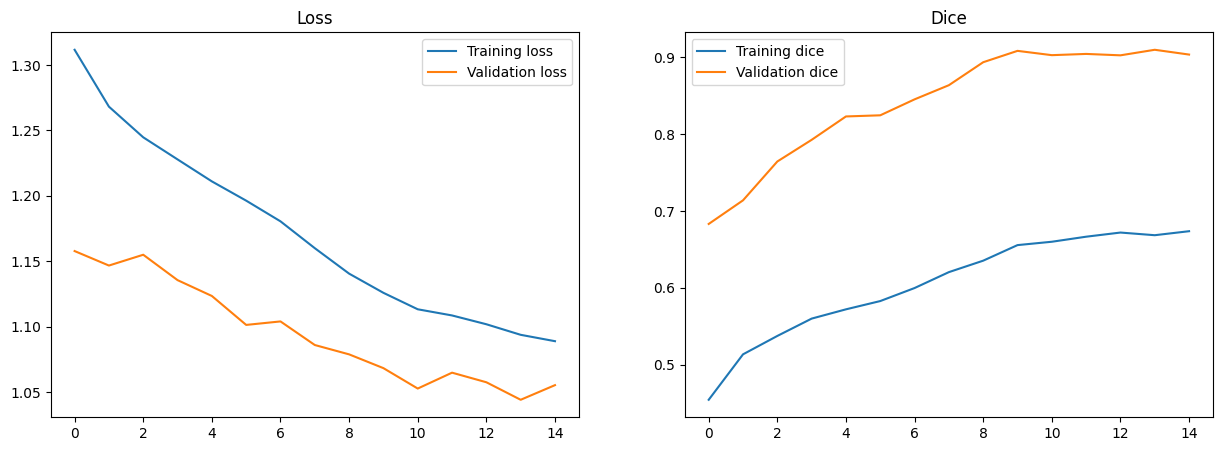

In [23]:
num_epochs = 15
learning_rate = 1e-5
optimizer = torch.optim.AdamW(custom.parameters(), lr=learning_rate)
Custom = Train(model = custom,
               model_name = "Custom",
               num_epochs = 15,
               train_dataloader = Train_Dataloader,
               valid_dataloader = Valid_Dataloader,
               loss_fn = CEDice,
               optimizer = optimizer,
               metric_fn = mnDice
               )



---



# **Part 5: Evaluating the Trained Models**

**Part 5.1: Evaluating Trained UFlex**

Now it's time to see what we have achieved in this session. For this purpose, we will use the "predictions" function that we defined in section 4.3.

We trained two different models on our dataset. In this part, we will evaluate our UFlex model and in the next part, we will do the same for our CustomUNet model.

Feel free to compare these results with the ones we obtained in section 4.3.

Here is the first output of this batch:

metatensor([[[ 1.6934,  2.3535,  2.8613,  ...,  2.4812,  2.1881,  1.5779],
         [ 2.4744,  2.6707,  3.2495,  ...,  2.8989,  2.5873,  1.8228],
         [ 2.7146,  2.6603,  3.0624,  ...,  2.6109,  2.2986,  1.8295],
         ...,
         [ 2.3720,  2.7490,  3.4446,  ...,  3.4588,  2.6373,  1.9235],
         [ 2.3889,  2.7481,  3.2199,  ...,  3.3461,  2.7266,  1.9223],
         [ 1.6492,  1.6511,  1.8555,  ...,  2.0827,  1.7477,  0.8430]],

        [[-1.7064, -2.4945, -2.7305,  ..., -2.6724, -2.5734, -1.8064],
         [-2.3883, -3.6707, -3.8886,  ..., -4.0675, -4.0904, -3.0891],
         [-2.8888, -3.9436, -4.2411,  ..., -4.1930, -4.2044, -3.0833],
         ...,
         [-2.6887, -4.0190, -4.1617,  ..., -4.3705, -4.5524, -2.8475],
         [-2.8668, -4.3663, -4.7677,  ..., -4.4573, -4.5004, -2.5906],
         [-2.1253, -3.3162, -3.6337,  ..., -3.3664, -3.3234, -1.9889]]],
       device='cuda:0', grad_fn=<AliasBackward0>) 

The dice coefficien

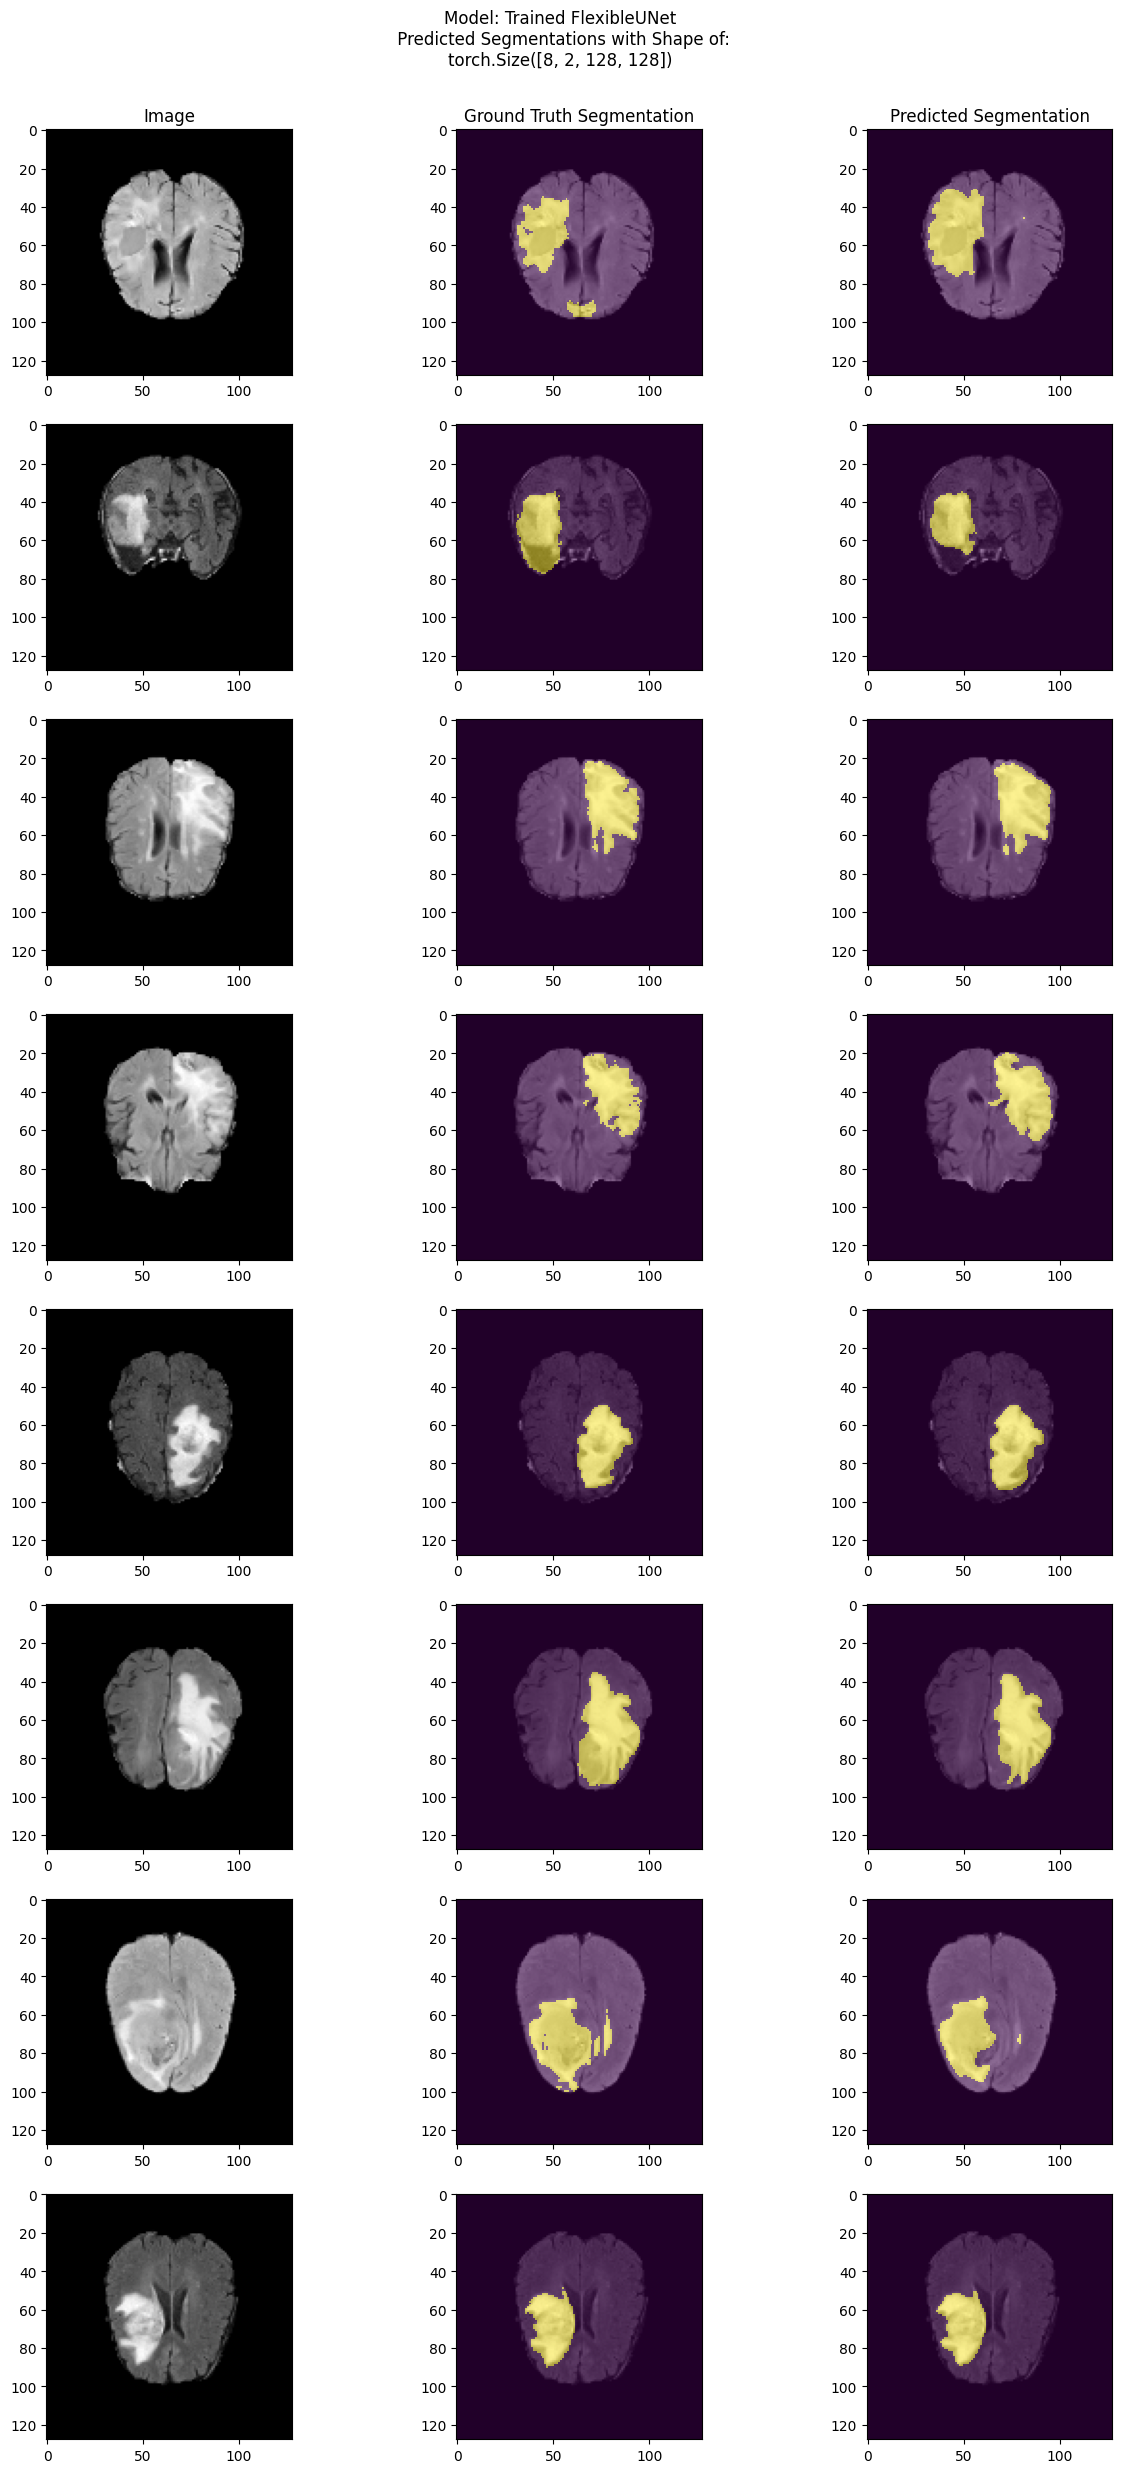

In [34]:
predictions(Model = U_Flex, Model_Name = "Trained FlexibleUNet" , Dataloader = Test_Dataloader)



---



**Part 5.2: Evaluating Trained CustomUNet**

Now it's time for our precious custom model. Let's see it's power!

Here is the first output of this batch:

metatensor([[[0.4196, 0.4097, 0.4364,  ..., 0.4343, 0.4162, 0.3513],
         [0.4806, 0.5018, 0.5269,  ..., 0.5208, 0.4810, 0.3675],
         [0.5247, 0.5227, 0.5449,  ..., 0.5473, 0.5264, 0.4226],
         ...,
         [0.5214, 0.5283, 0.5443,  ..., 0.5487, 0.5264, 0.4212],
         [0.4834, 0.4879, 0.5207,  ..., 0.5222, 0.4917, 0.3779],
         [0.4587, 0.4686, 0.4886,  ..., 0.4885, 0.4553, 0.3875]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0', grad_fn=<AliasBackward0>) 

The dice coefficient of record 1 in this batch:
Background: 0.9834, Tumor: 0.7265

The dice

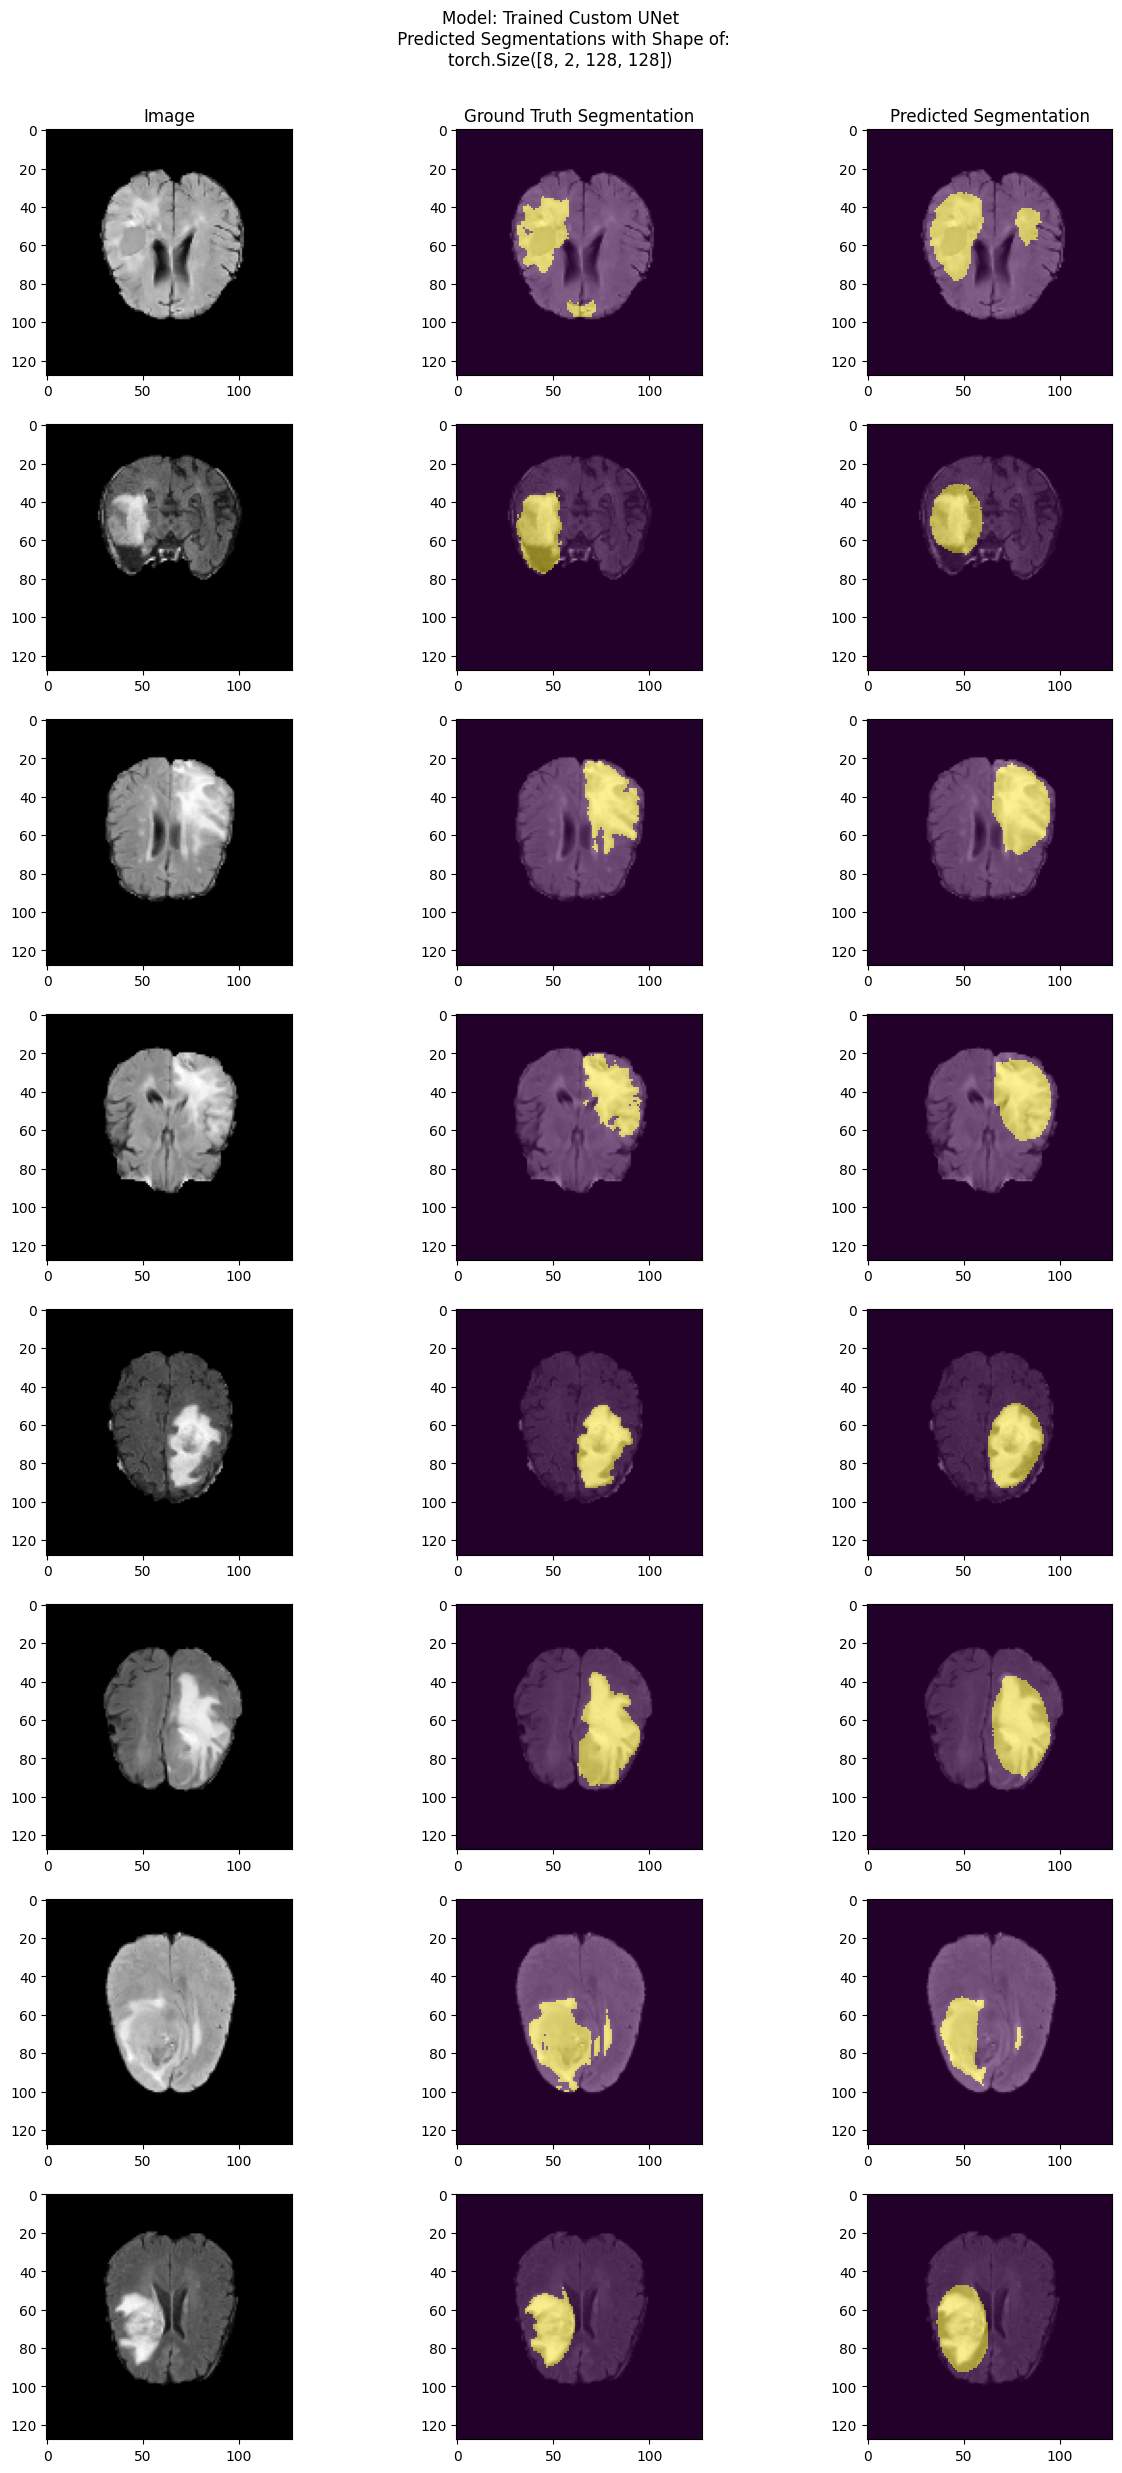

In [35]:
predictions(Model= Custom , Model_Name = "Trained Custom UNet" , Dataloader= Test_Dataloader)



---



As expected, our custom model is not able to outperform the powerful UFlex model in just 15 epochs. However, considering that our model has almost three times more parameters, it is entirely possible for it to outperform the pretrained UFlex model with more training epochs. Nonetheless, we gave it our best shot in 15 epochs, and the results were still quite impressive.

That's all for now. I just wanted to express my gratitude for coming along with me this far.

See you soon!